**MSc Computational Physics AUTh**<br>
**Academic Year: 2024-2025**<br>
**Master's Thesis**<br>

**Thesis Title:**<br>  
# **"Reconstruction of the EoSs of Exotic Stars using ML and ANNs regression models"**

**Implemented by: Ioannis Stergakis**<br>
**AEM: 4439**<br>

**Jupyter Notebook: JN10**<br>
**Name: "reconstruct_EOS_QS.ipynb"**<br>

**Description:**<br> 
**Reconstructing EoSs of Quark Stars**


**Abbrevations:**<br>
**1. NS -> Neutron Star**<br>
**2. QS -> Quark Star**<br>
**3. ML -> Machine Learning**<br>
**4. DL -> Deep Learning**<br>
**5. DNN -> Deep Neural Network**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_log_error
from ExoticStarsDataHandling import *

# 1. Preliminaries

In [2]:
def predict_EOS_mitbagQS(axis_EOS,axis_MR,mitbag_EOS,reg_models_infos:np.ndarray,points_MR,Pc_points,iterations,include_Mmax=True):
    num_pcpoints = len(Pc_points)
    num,num_models= np.shape(reg_models_infos)

    print(f"> {mitbag_EOS}")
    filename = f"{mitbag_EOS}_sol.csv"
    EOS_data = pd.read_csv(filename)

    slope_values,enrg_values,pc_mmax,enrg_mmax = QSdata().sample_EOS(filename,Pc_points,violate_caus="both")
    
    Pc_data = EOS_data.iloc[:,1]
    Ec_data = EOS_data.iloc[:,2]
    M_data = EOS_data.iloc[:,4]
    R_data = EOS_data.iloc[:,5]

    data_columns = EOS_data.columns
    B_col = data_columns[-1]
    B_val = float(B_col[3:])
    
    M_points = np.zeros([iterations,points_MR])
    R_points = np.zeros([iterations,points_MR])

    Enrg_true = np.tile(enrg_values,(iterations,1))
    #print(Enrg_true)

    models_predictions = np.zeros([num_models,iterations,num_pcpoints])
    #print(models_predictions)

    msle_results = np.zeros((num_models,1))
    #print(msle_results)

    # Plotting
    QSdata().plot_EOS_curve(filename=filename,axis_EOS=axis_EOS,clr_caus="cornflowerblue",curve_label=f"{mitbag_EOS} ({B_val:.1f})")
    if include_Mmax:
        axis_EOS.plot(pc_mmax,enrg_mmax,"s",ms=7,color="black",label=r"$M_{max}$ pt. "+f"({pc_mmax:.1f},{enrg_mmax:.1f})")
    QSdata().plot_MR_curve(filename=filename,axis_MR=axis_MR,clr_caus="cornflowerblue",clr_caus_3d="black",curve_label=f"{mitbag_EOS} ({B_val:.1f}) M-R")
    
    for i in range(0,iterations):
        #print(i)
        M_sample,R_sample = QSdata().sample_MR(filename,points_MR=points_MR,M_threshold=0.2,violate_caus="both",noiseM_std=0.1,noiseR_std=0.5)

        idx_shuffle = np.arange(0,len(M_sample))
        np.random.shuffle(idx_shuffle)
        # display(idx_shuffle)

        M_sample_sh = M_sample[idx_shuffle]
        R_sample_sh = R_sample[idx_shuffle]

        M_points[i]=M_sample
        R_points[i]=R_sample

        X_data = np.concatenate([M_sample_sh,R_sample_sh])
        # display(X_data)

        for k in range(0,num_models):
            model_file = reg_models_infos[0][k]
            model_info = joblib.load(model_file)
            model_name = reg_models_infos[1][k]

            Enrg_predictions = np.zeros((1,num_pcpoints))
            if model_name in ["dtree","rf","gradboost","xgboost"]:
                model_scaler_x = model_info["data_info"]["data_scaler"]
                model_estimator = model_info["best_estimator"]["model"]
                X_data_scaled = model_scaler_x.transform([X_data])
                Enrg_predictions = model_estimator.predict(X_data_scaled)
            elif model_name.count("dnn")>0:
                model_scaler_x = model_info["data_info"]["data_scaler"]["X"]
                model_estimator = model_info["estimator"]   
                X_data_scaled = model_scaler_x.transform([X_data])
                Enrg_predictions = model_estimator.predict(X_data_scaled, verbose=0)

            models_predictions[k][i] = Enrg_predictions

            #print(models_predictions)


    for k in range(0,num_models):
        #print(models_predictions[k])
        pred_avgs = np.average(models_predictions[k],axis=0)
        pred_std = np.std(models_predictions[k],axis=0)
        model_name = reg_models_infos[1][k]
        msle_results[k]=mean_squared_log_error(Enrg_true,models_predictions[k],multioutput="uniform_average")
        if model_name=="dtree":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="orange",label=model_name)
        elif model_name=="rf":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="green",label=model_name)    
        elif model_name=="gradboost":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="purple",label=model_name)
        elif model_name=="xgboost":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="red",label=model_name)    
        elif model_name.count("dnn3")>0:
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="grey",label=model_name)
            
          


    M_points_avgs = np.average(M_points,axis=0)
    R_points_avgs = np.average(R_points,axis=0)

    M_points_std = np.std(M_points,axis=0)
    R_points_std = np.std(R_points,axis=0)

    for i in range(0,len(R_sample_sh)):
        axis_MR.errorbar(R_points_avgs[i],M_points_avgs[i],xerr=R_points_std[i],yerr=M_points_std[i],ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6)
        axis_MR.text(R_points_avgs[i]-0.4,M_points_avgs[i]-0.1,f"{i+1}")  
    
    axis_EOS.set_xlabel(r"$P_c$ $[MeV\cdot fm^{-3}]$")
    axis_EOS.set_ylabel(r"$E_c$ $[MeV\cdot fm^{-3}]$")
    axis_EOS.legend()

    axis_MR.set_xlabel(r"$R$ $[km]$")
    axis_MR.set_ylabel(r"$M(M_\odot)$")
    axis_MR.set_xbound([0,12])
    axis_MR.legend()

    # Printing a summary
    best_msle = np.min(msle_results)
    best_msle_idx = np.argmin(msle_results)
    best_model = reg_models_infos[1][best_msle_idx] 
    print(f"\n>> POINTS M-R: {points_MR}")
    print("---------------------------------------------------------------------")
    print("Regression models and MSLE:")
    for k in range(0,num_models):
        print(f"{reg_models_infos[1][k]}:  {msle_results[k][0]}")
    print("---------------------------------------------------------------------")
    print("Best model:")
    print(best_model)
    print("Best model MSLE:")
    print(best_msle)
    print("---------------------------------------------------------------------\n\n")
    

In [3]:
def predict_EOS_cflQS(axis_EOS,axis_MR,cfl_EOS,reg_models_infos:np.ndarray,points_MR,Pc_points,iterations,include_Mmax=True):
    num_pcpoints = len(Pc_points)
    num,num_models= np.shape(reg_models_infos)

    print(f"> {cfl_EOS}")
    filename = f"{cfl_EOS}_sol.csv"
    EOS_data = pd.read_csv(filename)

    slope_values,enrg_values,pc_mmax,enrg_mmax = QSdata().sample_EOS(filename,Pc_points,violate_caus="both")
    
    Pc_data = EOS_data.iloc[:,1]
    Ec_data = EOS_data.iloc[:,2]
    M_data = EOS_data.iloc[:,4]
    R_data = EOS_data.iloc[:,5]

    data_columns = EOS_data.columns
    B_col = data_columns[-2]
    B_val = float(B_col[7:])

    Delta_col = data_columns[-1]
    Delta_val = float(Delta_col[6:])
    
    M_points = np.zeros([iterations,points_MR])
    R_points = np.zeros([iterations,points_MR])

    Enrg_true = np.tile(enrg_values,(iterations,1))
    #print(Enrg_true)

    models_predictions = np.zeros([num_models,iterations,num_pcpoints])
    #print(models_predictions)

    msle_results = np.zeros((num_models,1))
    #print(msle_results)

    # Plotting
    QSdata().plot_EOS_curve(filename=filename,axis_EOS=axis_EOS,clr_caus="cornflowerblue",curve_label=f"{cfl_EOS} ({B_val:.1f},{Delta_val:.1f})")
    if include_Mmax:
        axis_EOS.plot(pc_mmax,enrg_mmax,"s",ms=7,color="black",label=r"$M_{max}$ pt. "+f"({pc_mmax:.1f},{enrg_mmax:.1f})")
    QSdata().plot_MR_curve(filename=filename,axis_MR=axis_MR,clr_caus="cornflowerblue",clr_caus_3d="black",curve_label=f"{cfl_EOS} ({B_val:.1f}) M-R")
    
    for i in range(0,iterations):
        #print(i)
        M_sample,R_sample = QSdata().sample_MR(filename,points_MR=points_MR,M_threshold=0.2,violate_caus="both",noiseM_std=0.1,noiseR_std=0.5)

        idx_shuffle = np.arange(0,len(M_sample))
        np.random.shuffle(idx_shuffle)
        # display(idx_shuffle)

        M_sample_sh = M_sample[idx_shuffle]
        R_sample_sh = R_sample[idx_shuffle]

        M_points[i]=M_sample
        R_points[i]=R_sample

        X_data = np.concatenate([M_sample_sh,R_sample_sh])
        # display(X_data)

        for k in range(0,num_models):
            model_file = reg_models_infos[0][k]
            model_info = joblib.load(model_file)
            model_name = reg_models_infos[1][k]

            Enrg_predictions = np.zeros((1,num_pcpoints))
            if model_name in ["dtree","rf","gradboost","xgboost"]:
                model_scaler_x = model_info["data_info"]["data_scaler"]
                model_estimator = model_info["best_estimator"]["model"]
                X_data_scaled = model_scaler_x.transform([X_data])
                Enrg_predictions = model_estimator.predict(X_data_scaled)
            elif model_name.count("dnn")>0:
                model_scaler_x = model_info["data_info"]["data_scaler"]["X"]
                model_estimator = model_info["estimator"]   
                X_data_scaled = model_scaler_x.transform([X_data])
                Enrg_predictions = model_estimator.predict(X_data_scaled, verbose=0)

            models_predictions[k][i] = Enrg_predictions

            #print(models_predictions)


    for k in range(0,num_models):
        #print(models_predictions[k])
        pred_avgs = np.average(models_predictions[k],axis=0)
        pred_std = np.std(models_predictions[k],axis=0)
        model_name = reg_models_infos[1][k]
        msle_results[k]=mean_squared_log_error(Enrg_true,models_predictions[k],multioutput="uniform_average")
        if model_name=="dtree":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="orange",label=model_name)
        elif model_name=="rf":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="green",label=model_name)    
        elif model_name=="gradboost":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="purple",label=model_name)
        elif model_name=="xgboost":
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="red",label=model_name)    
        elif model_name.count("dnn3")>0:
            axis_EOS.errorbar(Pc_points,pred_avgs,yerr=pred_std,ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6,color="grey",label=model_name)
            
          


    M_points_avgs = np.average(M_points,axis=0)
    R_points_avgs = np.average(R_points,axis=0)

    M_points_std = np.std(M_points,axis=0)
    R_points_std = np.std(R_points,axis=0)

    for i in range(0,len(R_sample_sh)):
        axis_MR.errorbar(R_points_avgs[i],M_points_avgs[i],xerr=R_points_std[i],yerr=M_points_std[i],ls="None",fmt='o',ms=3,elinewidth=0.8,capsize=6)
        axis_MR.text(R_points_avgs[i]-0.4,M_points_avgs[i]-0.1,f"{i+1}")  
    
    axis_EOS.set_xlabel(r"$P_c$ $[MeV\cdot fm^{-3}]$")
    axis_EOS.set_ylabel(r"$E_c$ $[MeV\cdot fm^{-3}]$")
    axis_EOS.legend()

    axis_MR.set_xlabel(r"$R$ $[km]$")
    axis_MR.set_ylabel(r"$M(M_\odot)$")
    axis_MR.set_xbound([0,18])
    axis_MR.legend()

    # Printing a summary
    best_msle = np.min(msle_results)
    best_msle_idx = np.argmin(msle_results)
    best_model = reg_models_infos[1][best_msle_idx] 
    print(f"\n>> POINTS M-R: {points_MR}")
    print("---------------------------------------------------------------------")
    print("Regression models and MSLE:")
    for k in range(0,num_models):
        print(f"{reg_models_infos[1][k]}:  {msle_results[k][0]}")
    print("---------------------------------------------------------------------")
    print("Best model:")
    print(best_model)
    print("Best model MSLE:")
    print(best_msle)
    print("---------------------------------------------------------------------\n\n")
    

In [4]:
# ML models names
models_16X_infos = [["QS_dtree_grid_enrg_16X_rwsh.pkl","QS_rf_grid_enrg_16X_rwsh.pkl","QS_xgboost_grid_enrg_16X_rwsh.pkl","QS_gradboost_grid_enrg_16X_rwsh.pkl","QS_dnn3_enrg_16X_rwsh.pkl"],
                ["dtree","rf","xgboost","gradboost","dnn3"]]

models_32X_infos = [["QS_dtree_grid_enrg_32X_rwsh.pkl","QS_rf_grid_enrg_32X_rwsh.pkl","QS_xgboost_grid_enrg_32X_rwsh.pkl","QS_gradboost_grid_enrg_32X_rwsh.pkl","QS_dnn3_enrg_32X_rwsh.pkl"],
                ["dtree","rf","xgboost","gradboost","dnn3"]]

# Pressure points
Pc_pts = [10,100,200,300,400,500,600,700,800,900,1000,1100]

# 2. Predicting MITbag EOSs

## **2.1 MITbag-15 ($B=67$ $MeV\cdot fm^{-3}$) results**

> MITbag-15

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.008720575430274475
rf:  0.005807401819270023
xgboost:  0.0037262649146766473
gradboost:  0.007634444982721561
dnn3:  0.0009723216081693733
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0009723216081693733
---------------------------------------------------------------------


> MITbag-15

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.008155235928906492
rf:  0.005502145763543562
xgboost:  0.0026068625728778907
gradboost:  0.006629632273890713
dnn3:  0.0008715996921492382
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0008715996921492382
---------------------------------------------------------------------




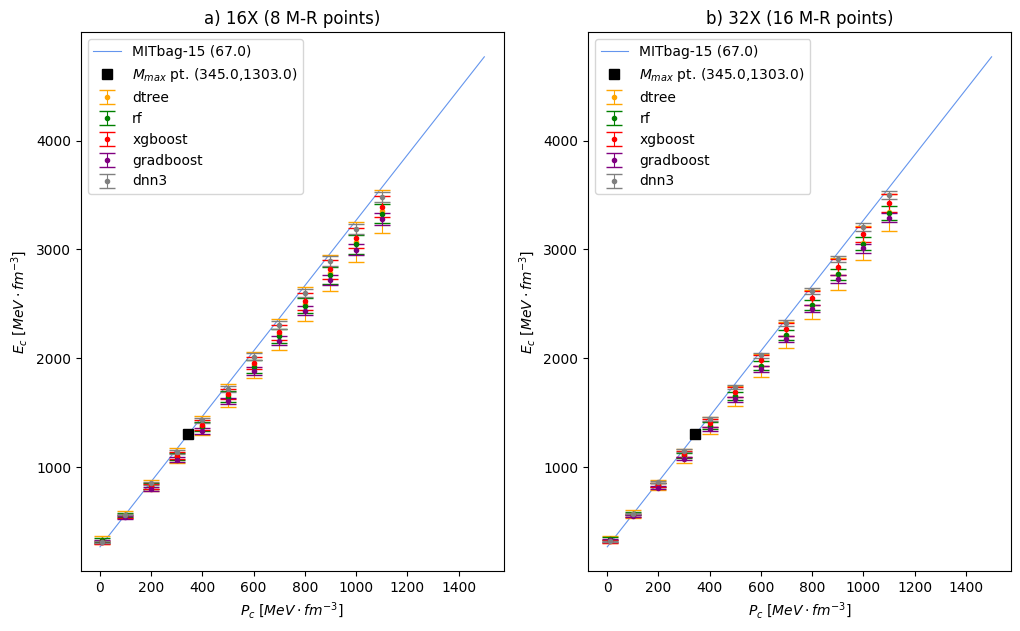

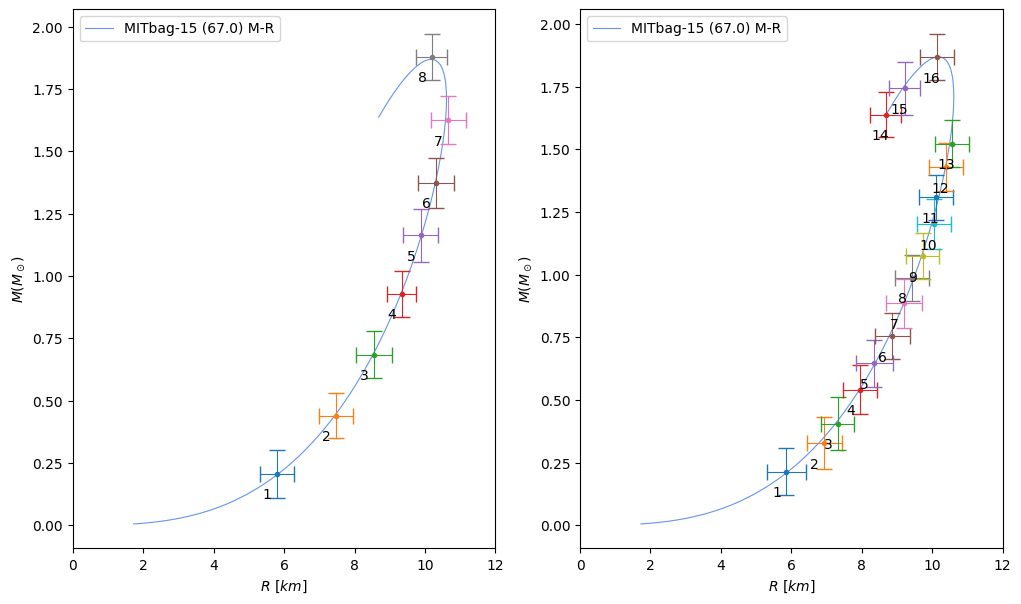

In [5]:
fig_MITbag15_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag15_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-15",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-15",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag15_EOS.savefig("MITbag-15_EOS_predict.png",dpi=300)
fig_MITbag15_MR.savefig("MITbag-15_MR_predict.png",dpi=300)

fig_MITbag15_EOS.savefig("MITbag-15_EOS_predict.pdf",dpi=300)

## **2.2 MITbag-18 ($B=68.5$ $MeV\cdot fm^{-3}$) results**

> MITbag-18

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.006067202697459269
rf:  0.004723377790431999
xgboost:  0.003521959036713503
gradboost:  0.006743382048105641
dnn3:  0.0009250598859502312
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0009250598859502312
---------------------------------------------------------------------


> MITbag-18

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.010046547920158222
rf:  0.006002919219866432
xgboost:  0.002870855625225204
gradboost:  0.006423593233821843
dnn3:  0.0013466866385644031
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0013466866385644031
---------------------------------------------------------------------




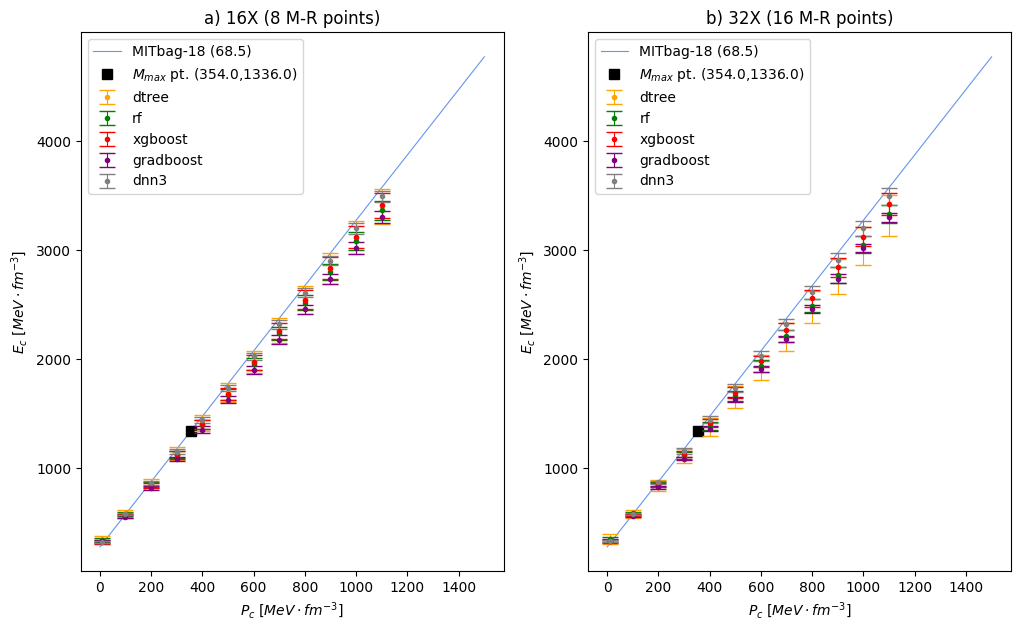

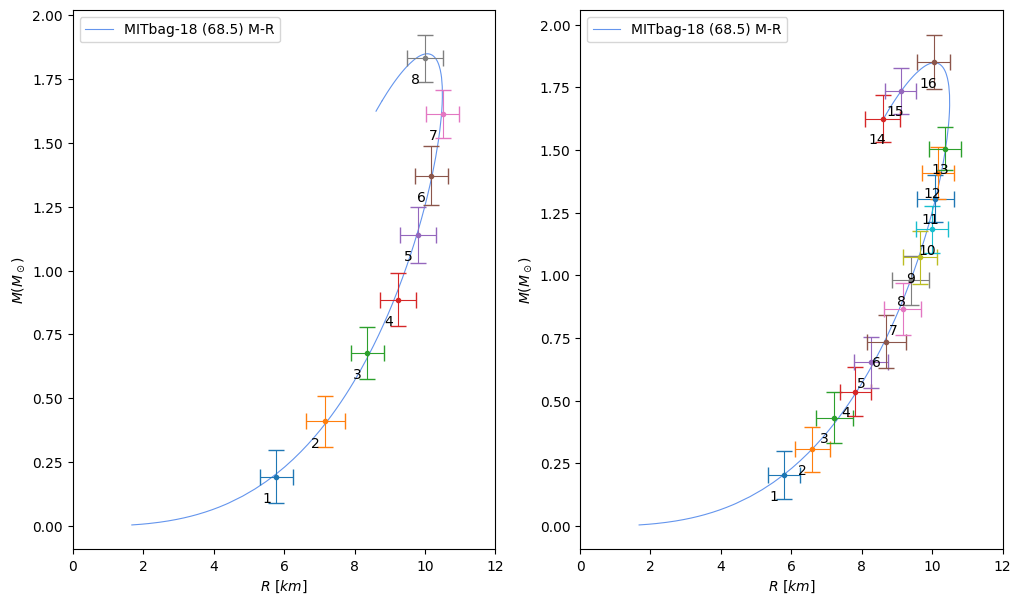

In [6]:
fig_MITbag18_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag18_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-18",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-18",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag18_EOS.savefig("MITbag-18_EOS_predict.pdf",dpi=300)

## **2.3 MITbag-86 ($B=102.5$ $MeV\cdot fm^{-3}$) results**

> MITbag-86

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.005765273304761828
rf:  0.00430202823770644
xgboost:  0.003841502135160195
gradboost:  0.005147063427347464
dnn3:  0.0027516264797248723
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0027516264797248723
---------------------------------------------------------------------


> MITbag-86

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.006042971633566292
rf:  0.004184730314745635
xgboost:  0.003076925617737534
gradboost:  0.004865296348741016
dnn3:  0.001726508916753846
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.001726508916753846
---------------------------------------------------------------------




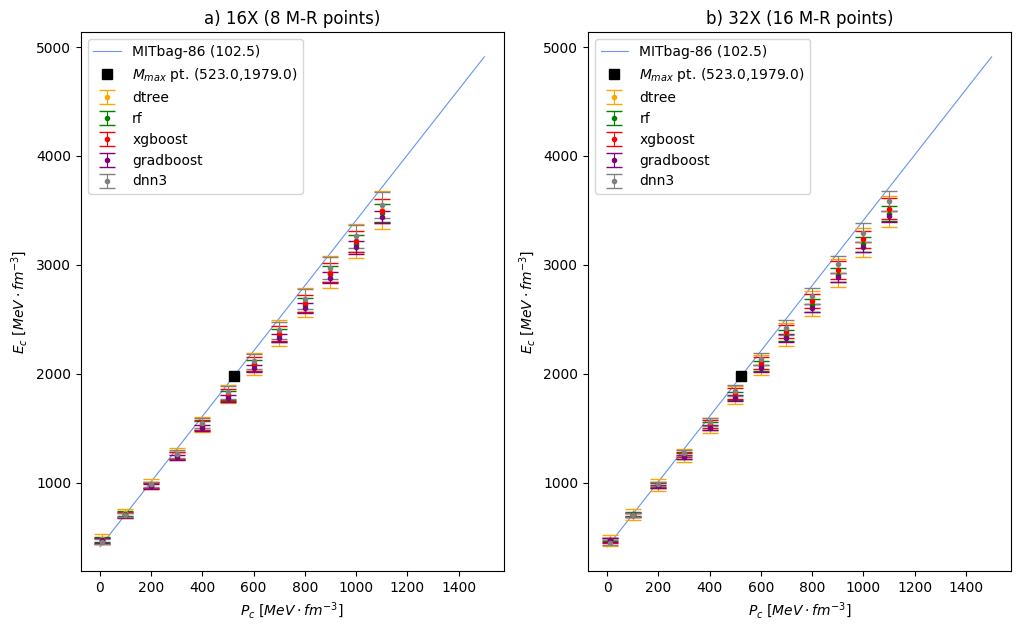

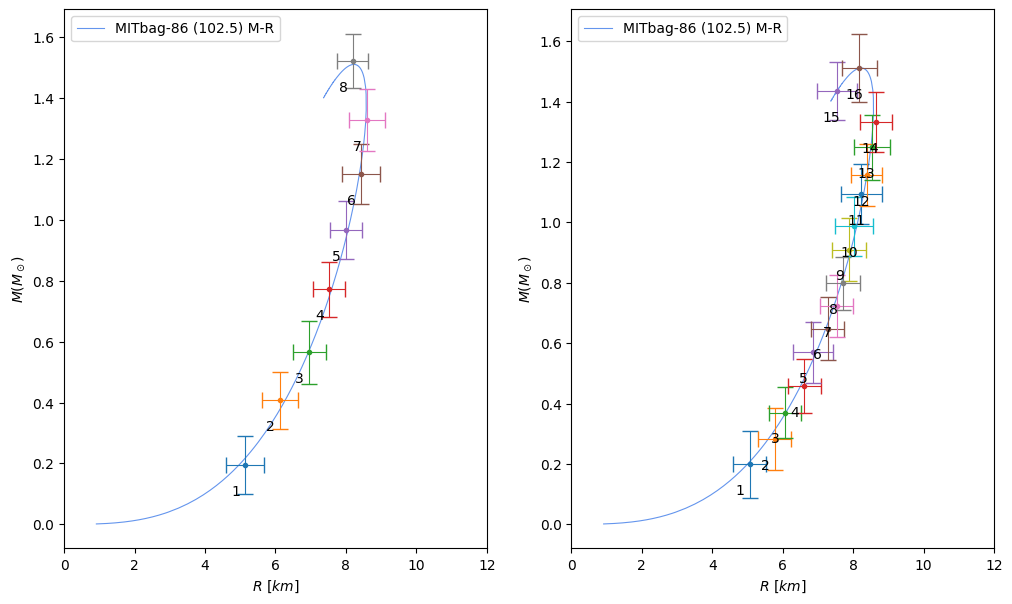

In [7]:
fig_MITbag86_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag86_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-86",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-86",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag86_EOS.savefig("MITbag-86_EOS_predict.pdf",dpi=300)

## **2.4 MITbag-134 ($B=126.5$ $MeV\cdot fm^{-3}$) results**

> MITbag-134

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.005704254175807833
rf:  0.00304955808222976
xgboost:  0.002924474543482413
gradboost:  0.003586727392292325
dnn3:  0.003922901086815506
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.002924474543482413
---------------------------------------------------------------------


> MITbag-134

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.006235162346080576
rf:  0.0029756177235790407
xgboost:  0.002549011986376111
gradboost:  0.003349747818467925
dnn3:  0.0018536672856872627
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0018536672856872627
---------------------------------------------------------------------




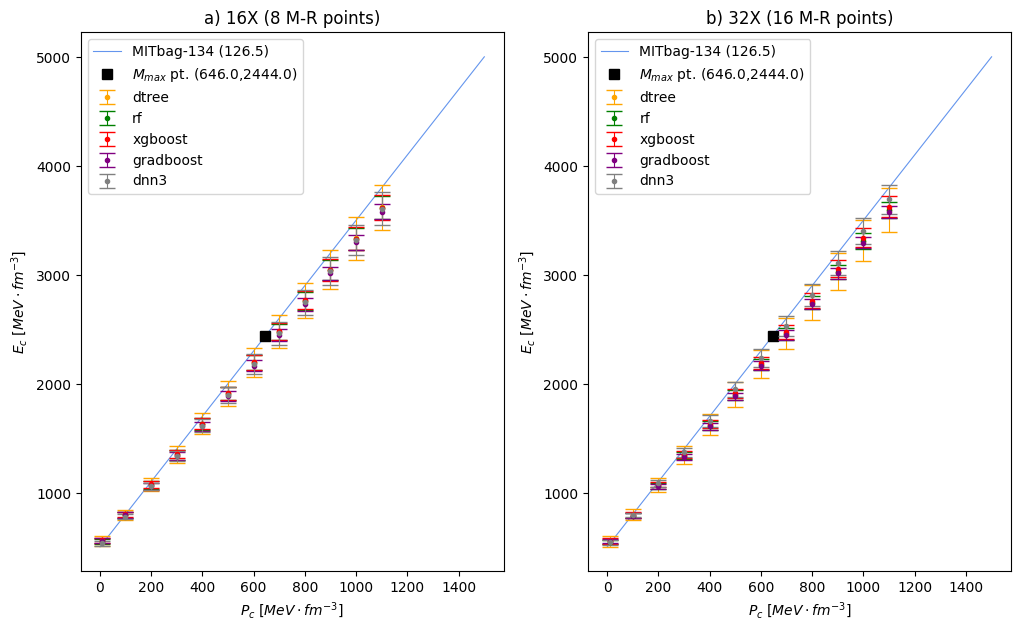

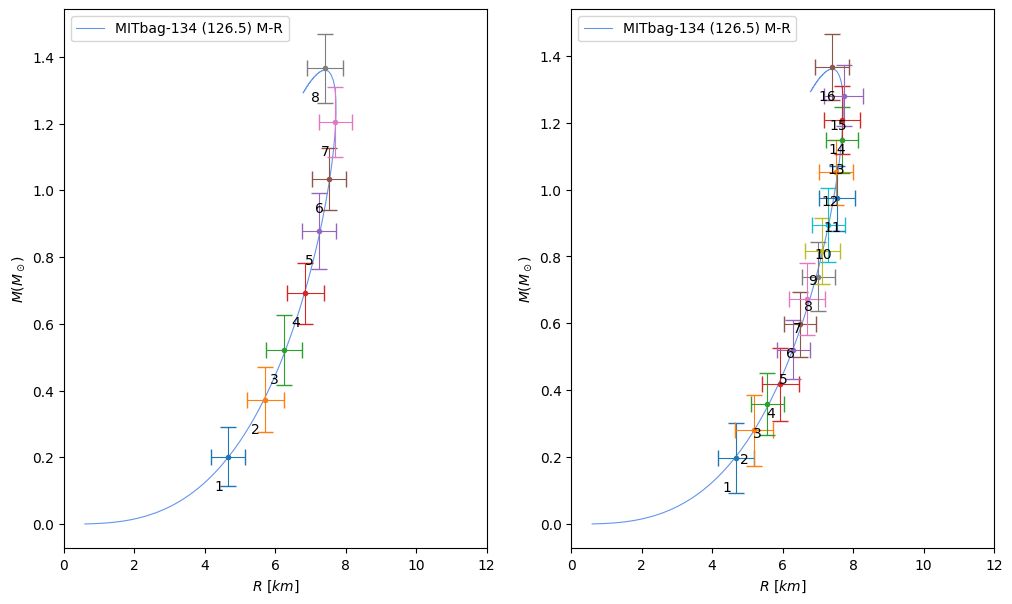

In [8]:
fig_MITbag134_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag134_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-134",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-134",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag134_EOS.savefig("MITbag-134_EOS_predict.pdf",dpi=300)

## **2.5 MITbag-197 ($B=158$ $MeV\cdot fm^{-3}$) results**

> MITbag-197

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0029220872132492957
rf:  0.0014268060576121764
xgboost:  0.0012620262804872954
gradboost:  0.0017955702396113954
dnn3:  0.0021215589899899966
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0012620262804872954
---------------------------------------------------------------------


> MITbag-197

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.005942803454530066
rf:  0.0009020859770638333
xgboost:  0.0009194760897377993
gradboost:  0.0010844692480642068
dnn3:  0.0002929814134257387
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0002929814134257387
---------------------------------------------------------------------




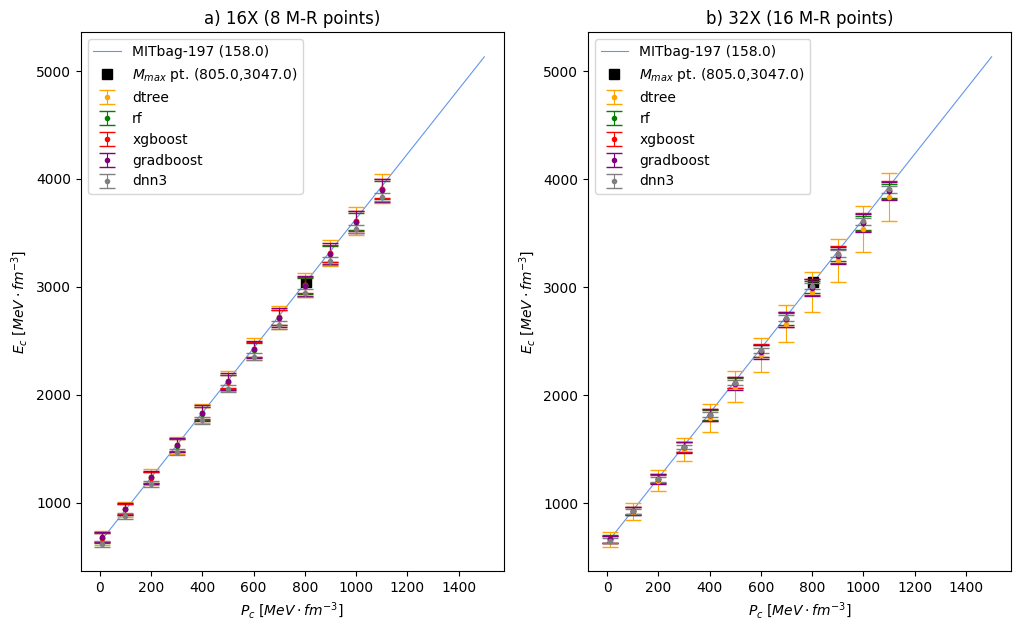

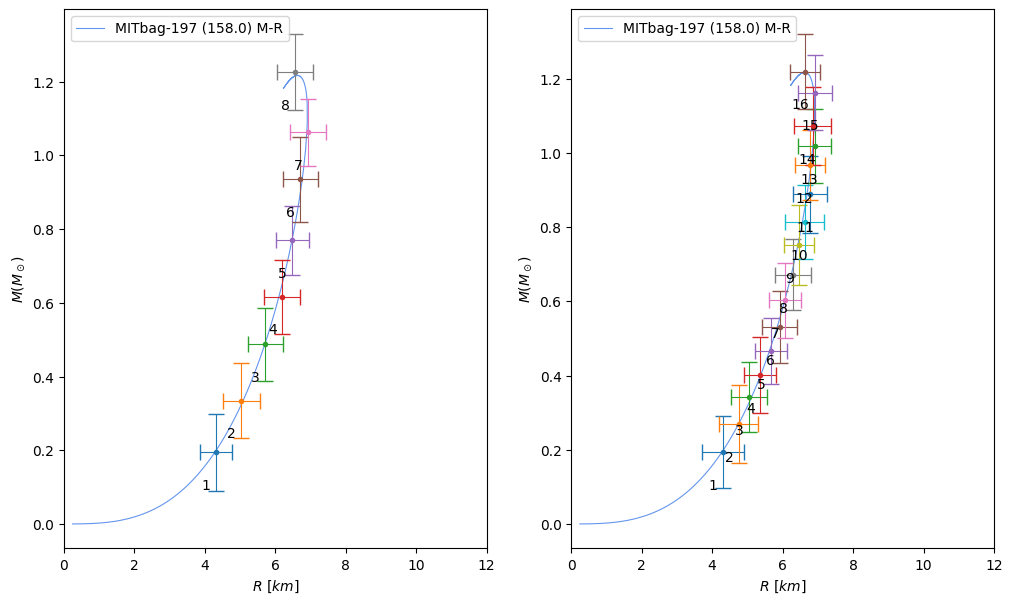

In [9]:
fig_MITbag197_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag197_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-197",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-197",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag197_EOS.savefig("MITbag-197_EOS_predict.pdf",dpi=300)

## **2.6 MITbag-227 ($B=173$ $MeV\cdot fm^{-3}$) results**

> MITbag-227

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0025112687260861236
rf:  0.0011122177396888295
xgboost:  0.0010730769797968889
gradboost:  0.001380849143829809
dnn3:  0.0030441187674466216
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0010730769797968889
---------------------------------------------------------------------


> MITbag-227

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.001821591259436933
rf:  0.0006915912881198398
xgboost:  0.0007119100142129903
gradboost:  0.0008874412865206837
dnn3:  0.0005226927625886147
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0005226927625886147
---------------------------------------------------------------------




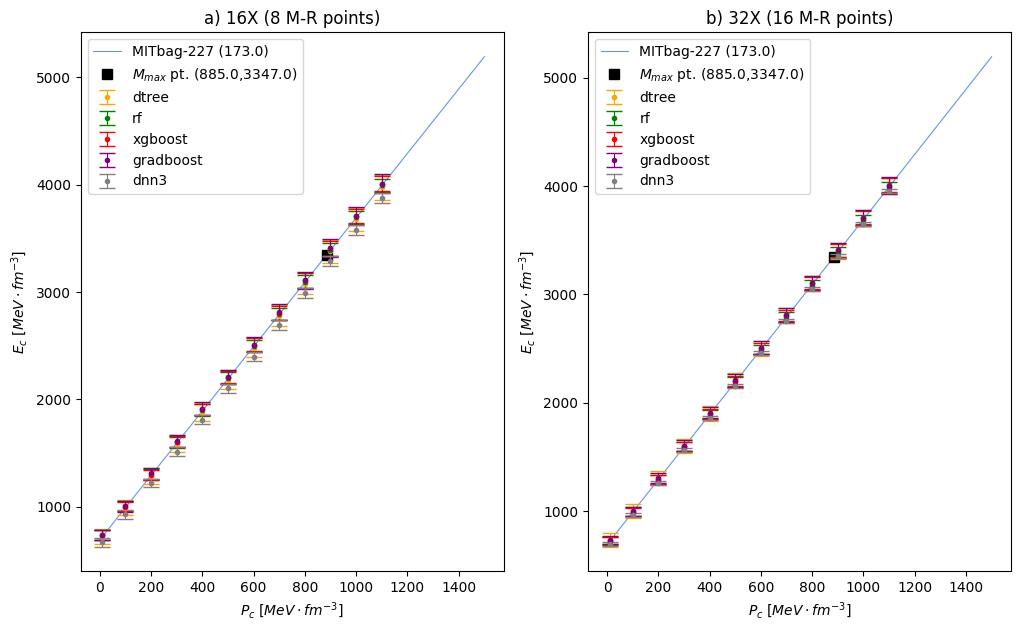

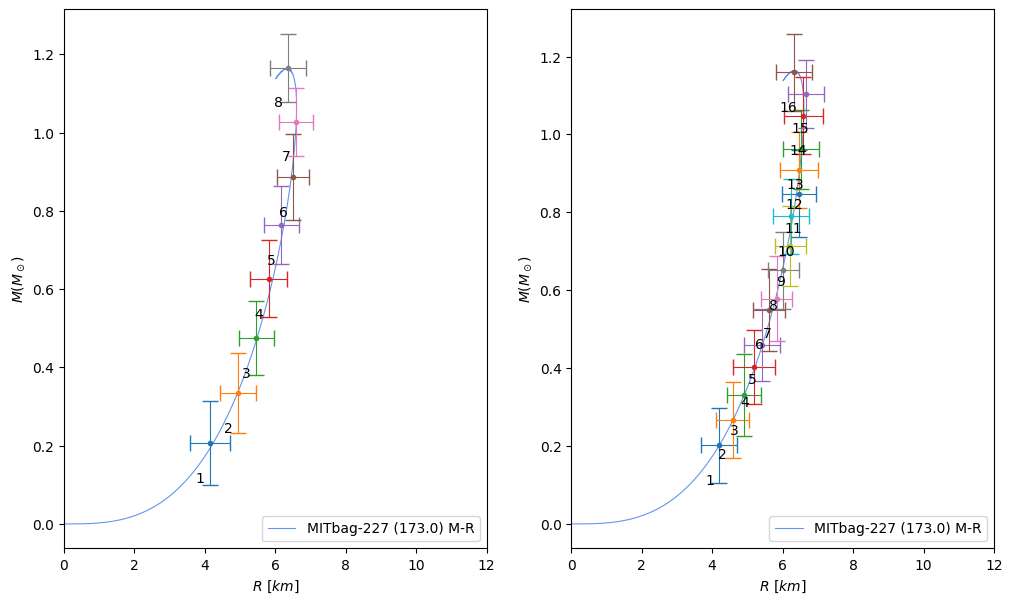

In [10]:
fig_MITbag227_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag227_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-227",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-227",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag227_EOS.savefig("MITbag-227_EOS_predict.pdf",dpi=300)

## **2.7 MITbag-274 ($B=196.5$ $MeV\cdot fm^{-3}$) results**

> MITbag-274

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.002187068162415239
rf:  0.000951499918071467
xgboost:  0.0007906350878969518
gradboost:  0.000993833513515636
dnn3:  0.002514097605439637
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0007906350878969518
---------------------------------------------------------------------


> MITbag-274

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0021616146660992934
rf:  0.0006133529954977756
xgboost:  0.0007761676913327606
gradboost:  0.0007623397039593559
dnn3:  0.001277173422799427
---------------------------------------------------------------------
Best model:
rf
Best model MSLE:
0.0006133529954977756
---------------------------------------------------------------------




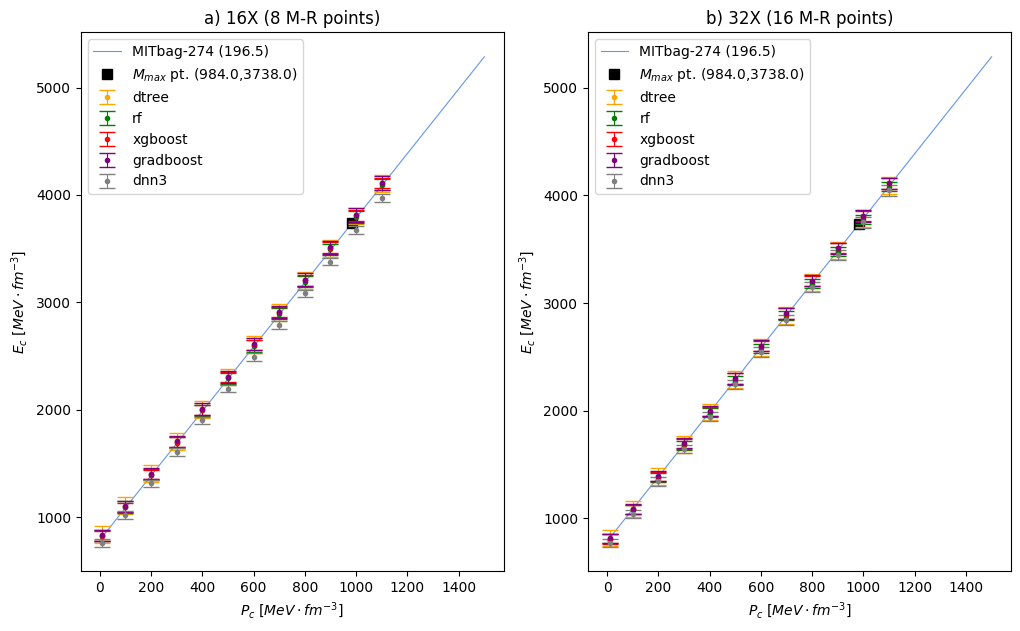

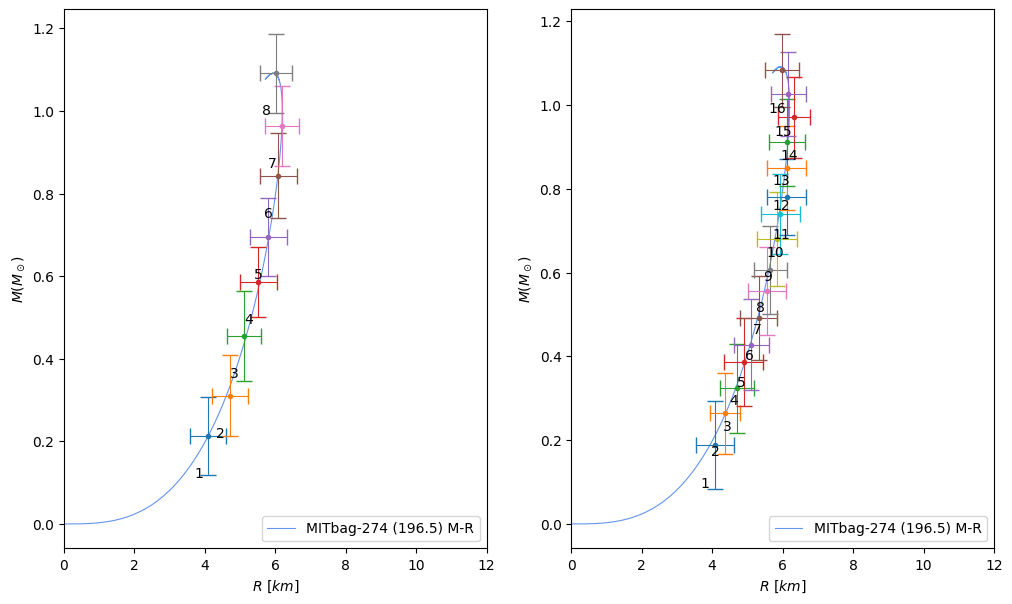

In [11]:
fig_MITbag274_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag274_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-274",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-274",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag274_EOS.savefig("MITbag-274_EOS_predict.pdf",dpi=300)

## **2.8 MITbag-297 ($B=208$ $MeV\cdot fm^{-3}$) results**

> MITbag-297

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.002155889640037529
rf:  0.0007565540858407873
xgboost:  0.0007309798597167676
gradboost:  0.0006233538892789915
dnn3:  0.003438476246535243
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0006233538892789915
---------------------------------------------------------------------


> MITbag-297

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.001904840491746279
rf:  0.0006259388034115896
xgboost:  0.0007047429484953984
gradboost:  0.000639341803319469
dnn3:  0.0006941757454582386
---------------------------------------------------------------------
Best model:
rf
Best model MSLE:
0.0006259388034115896
---------------------------------------------------------------------




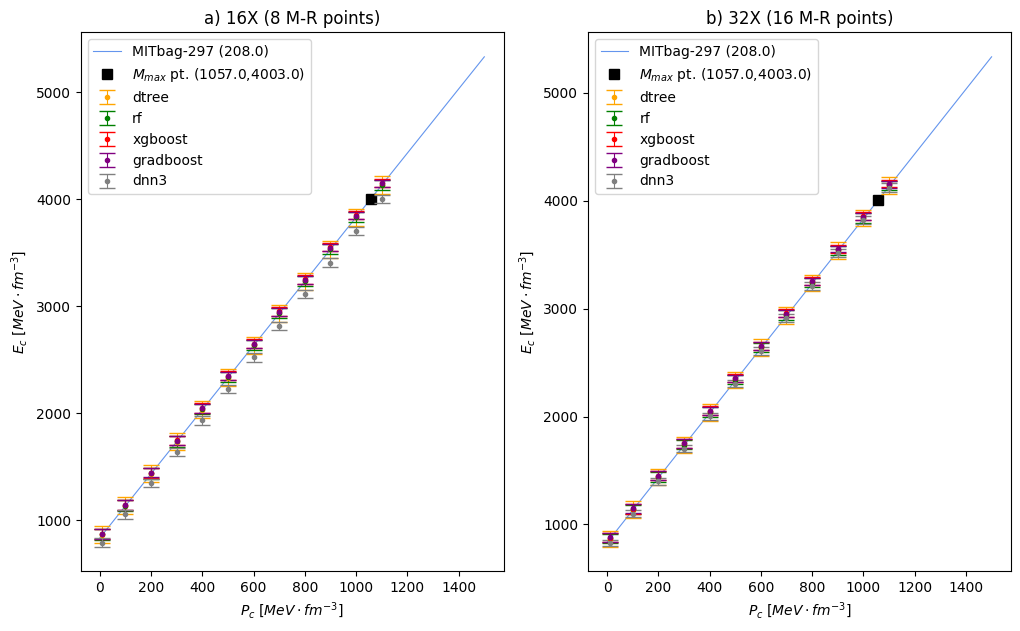

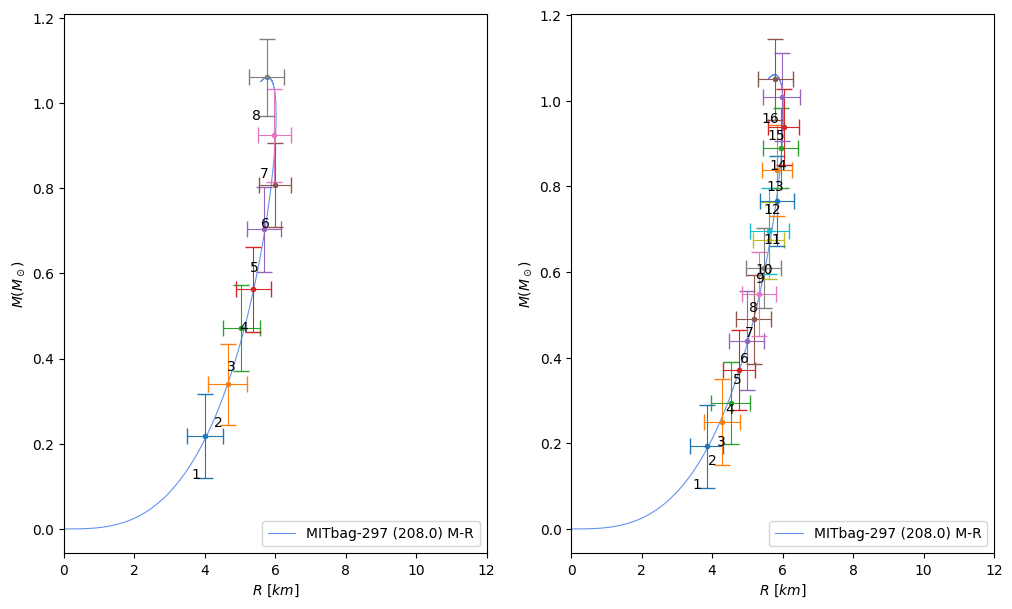

In [12]:
fig_MITbag297_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag297_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-297",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-297",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag297_EOS.savefig("MITbag-297_EOS_predict.pdf",dpi=300)

## **2.9 MITbag-315 ($B=217$ $MeV\cdot fm^{-3}$) results**

> MITbag-315

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.001843413509039388
rf:  0.000720211353843512
xgboost:  0.0005492011488275699
gradboost:  0.0006215869963594719
dnn3:  0.0035393801445073023
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0005492011488275699
---------------------------------------------------------------------


> MITbag-315

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0014791245061788535
rf:  0.0004488757809297686
xgboost:  0.0003689968680114845
gradboost:  0.00031101628410959393
dnn3:  0.0007192455848799122
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.00031101628410959393
---------------------------------------------------------------------




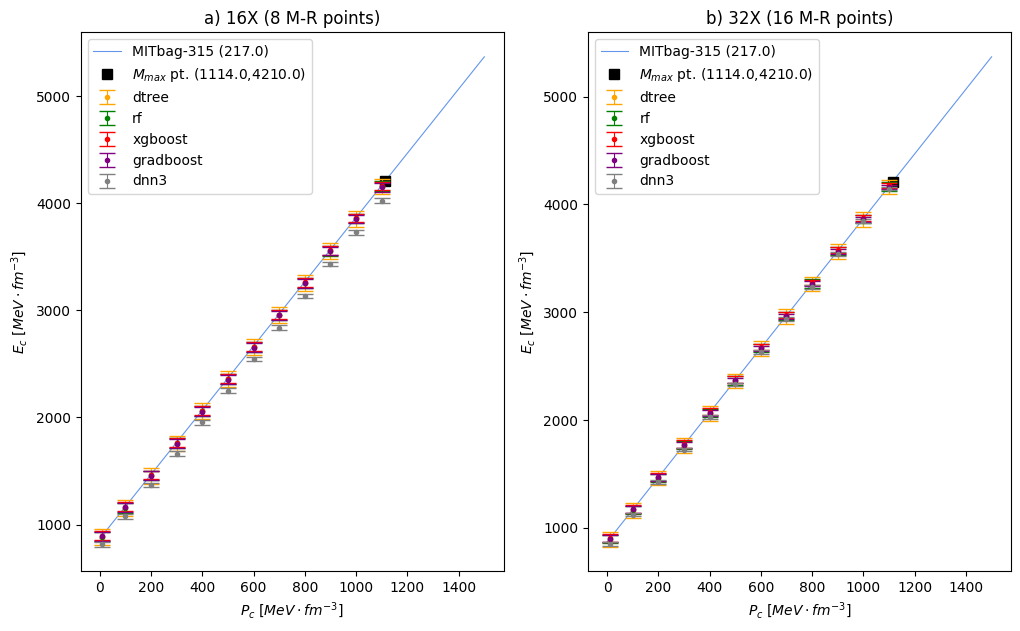

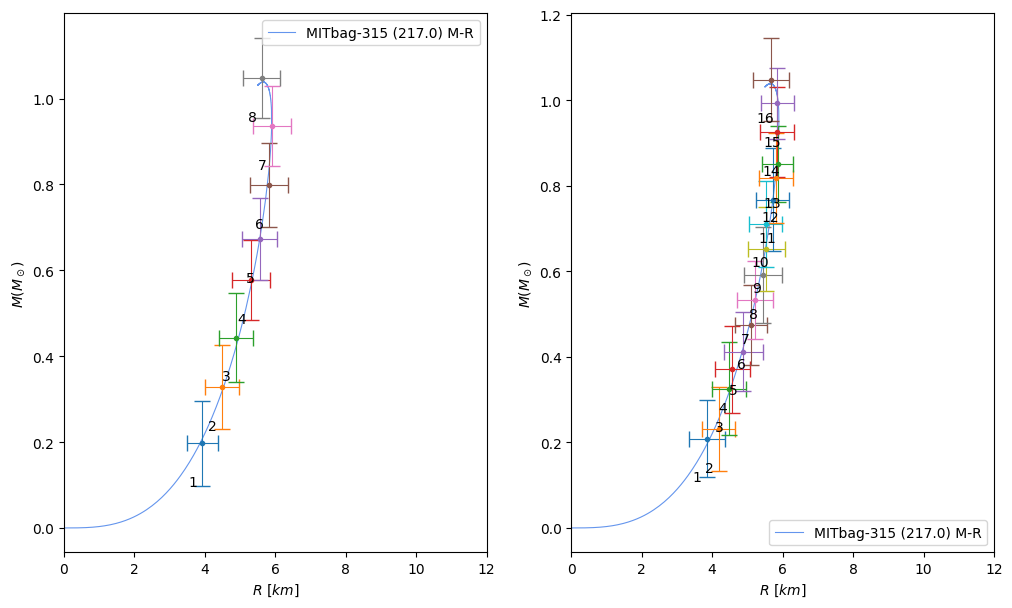

In [13]:
fig_MITbag315_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag315_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-315",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-315",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag315_EOS.savefig("MITbag-315_EOS_predict.pdf",dpi=300)

## **2.10 MITbag-367 ($B=243$ $MeV\cdot fm^{-3}$) results**

> MITbag-367

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0013872573275932184
rf:  0.001241856344888182
xgboost:  0.0009586552999360643
gradboost:  0.0015397270829970253
dnn3:  0.008398402965633808
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0009586552999360643
---------------------------------------------------------------------


> MITbag-367

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.0015630297270906677
rf:  0.0010969486828267471
xgboost:  0.0007816499412923306
gradboost:  0.0014145746487775784
dnn3:  0.0034999828392149363
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0007816499412923306
---------------------------------------------------------------------




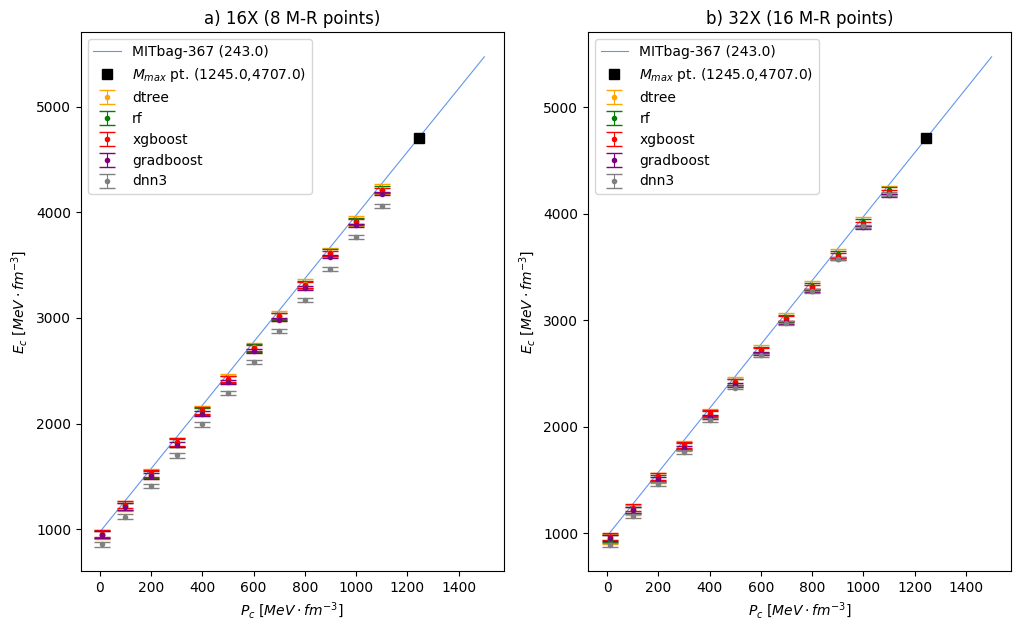

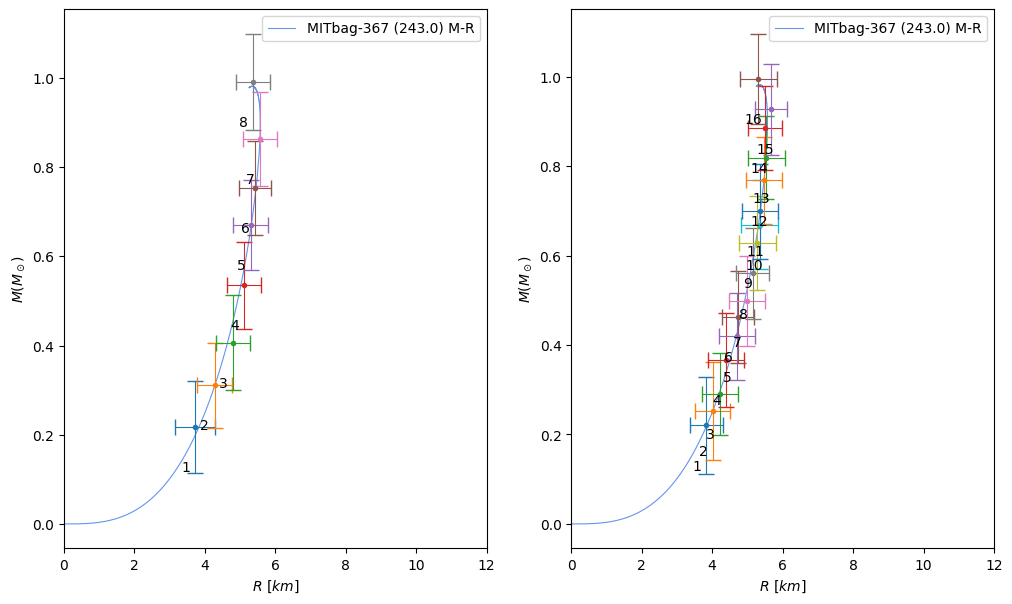

In [14]:
fig_MITbag367_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_MITbag367_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],mitbag_EOS="MITbag-367",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_mitbagQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],mitbag_EOS="MITbag-367",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_MITbag367_EOS.savefig("MITbag-367_EOS_predict.pdf",dpi=300)

# 3. Predicting CFL EOSs

## **3.1 CFL-8 ($B=60$ $MeV\cdot fm^{-3}$, $Δ=120$ $MeV$) results**

> CFL-8

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.018974601616152543
rf:  0.011925347085783614
xgboost:  0.009643435360249785
gradboost:  0.014880788690422518
dnn3:  0.004801370380004025
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.004801370380004025
---------------------------------------------------------------------


> CFL-8

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.019098235150306644
rf:  0.012435610137409382
xgboost:  0.00922921769824771
gradboost:  0.014012998843694292
dnn3:  0.001841873116431996
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.001841873116431996
---------------------------------------------------------------------




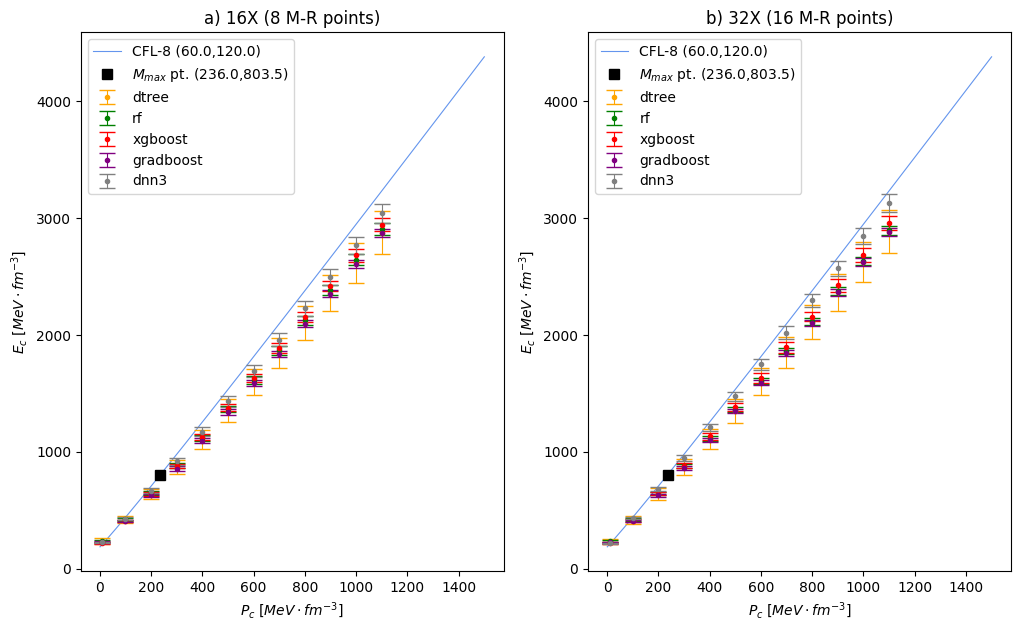

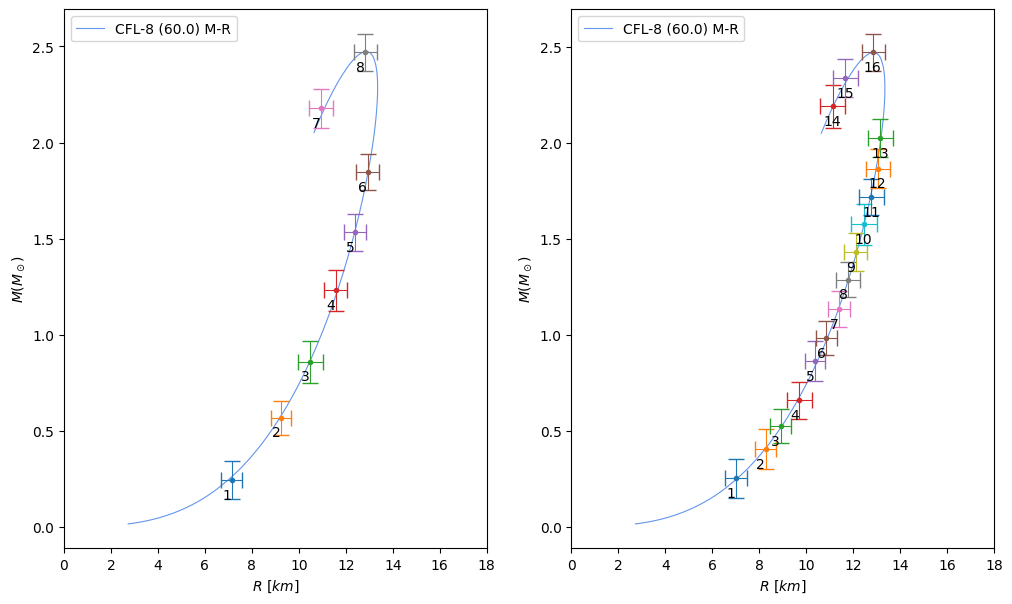

In [15]:
fig_CFL8_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL8_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-8",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-8",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL8_EOS.savefig("CFL-8_EOS_predict.pdf",dpi=300)

## **3.2 CFL-53 ($B=70$ $MeV\cdot fm^{-3}$, $Δ=150$ $MeV$) results**

> CFL-53

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.010307545638086378
rf:  0.004514372209286422
xgboost:  0.004090644940391961
gradboost:  0.005633208617107862
dnn3:  0.0022122315712132788
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0022122315712132788
---------------------------------------------------------------------


> CFL-53

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.012325591815798882
rf:  0.005009003017645449
xgboost:  0.004865632094883248
gradboost:  0.006356400413136922
dnn3:  0.0011867055611147832
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0011867055611147832
---------------------------------------------------------------------




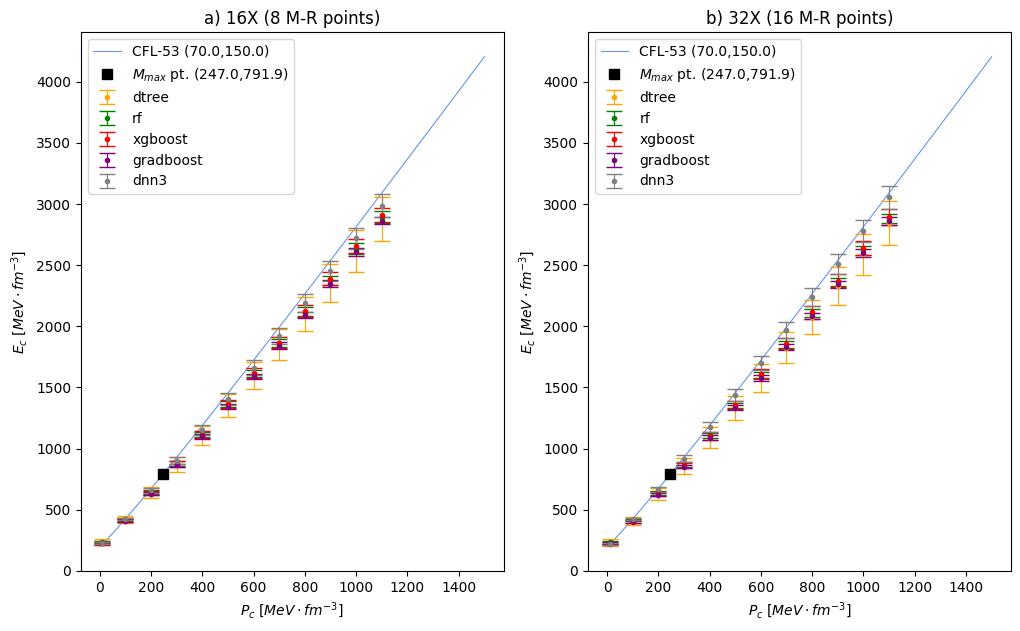

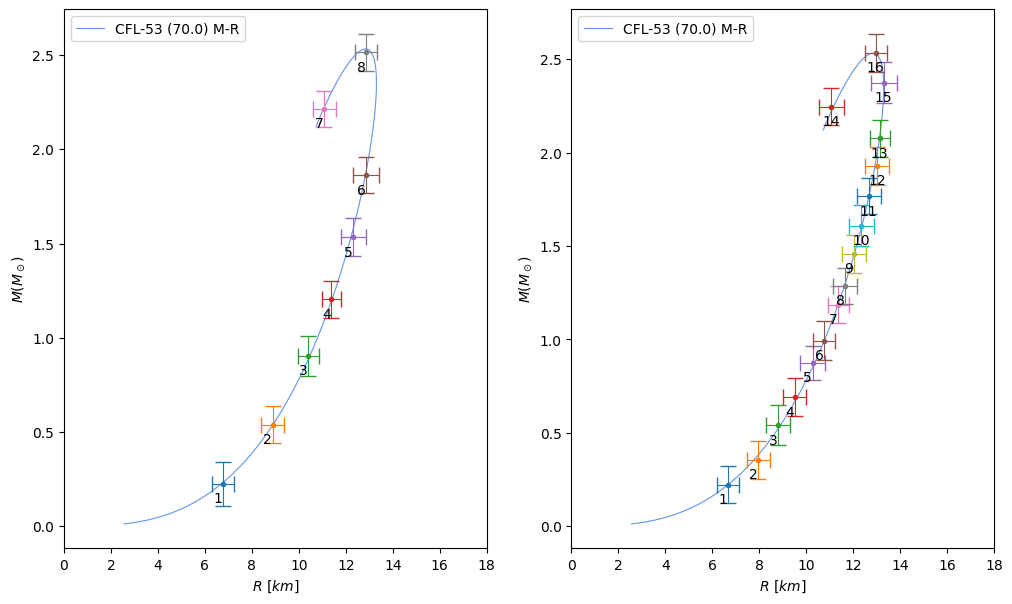

In [16]:
fig_CFL53_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL53_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-53",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-53",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL53_EOS.savefig("CFL-53_EOS_predict.pdf",dpi=300)

## **3.3 CFL-75 ($B=75$ $MeV\cdot fm^{-3}$, $Δ=160$ $MeV$) results**

> CFL-75

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.008155065957545093
rf:  0.002924388100569357
xgboost:  0.00295454563106539
gradboost:  0.0036233225707957045
dnn3:  0.0023682263990501603
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0023682263990501603
---------------------------------------------------------------------


> CFL-75

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.007792156850360803
rf:  0.0025890887594270766
xgboost:  0.0023085840063472155
gradboost:  0.002839226007705344
dnn3:  0.0020429490938002385
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0020429490938002385
---------------------------------------------------------------------




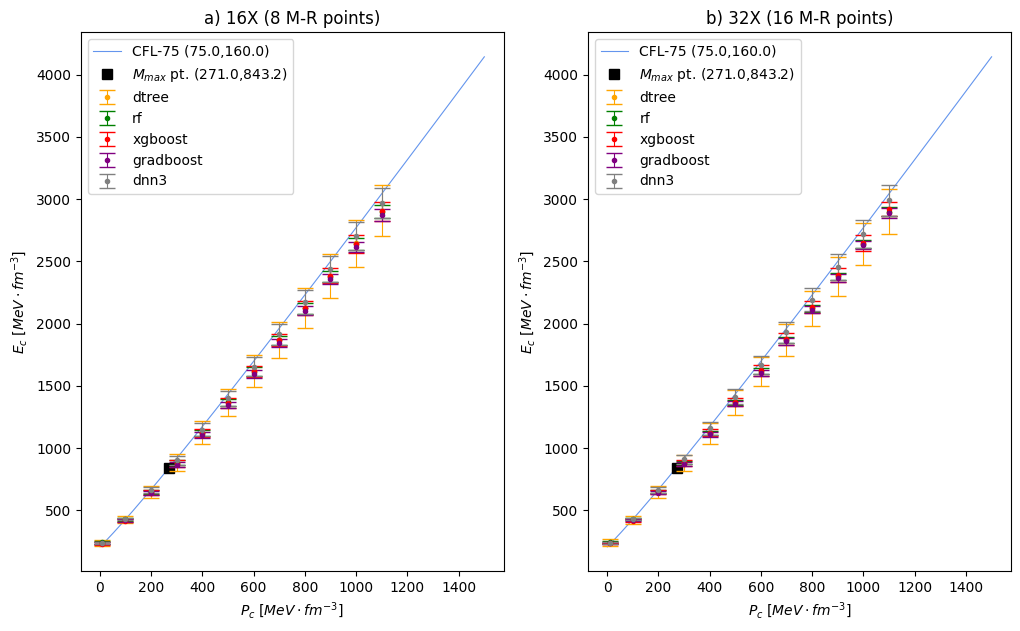

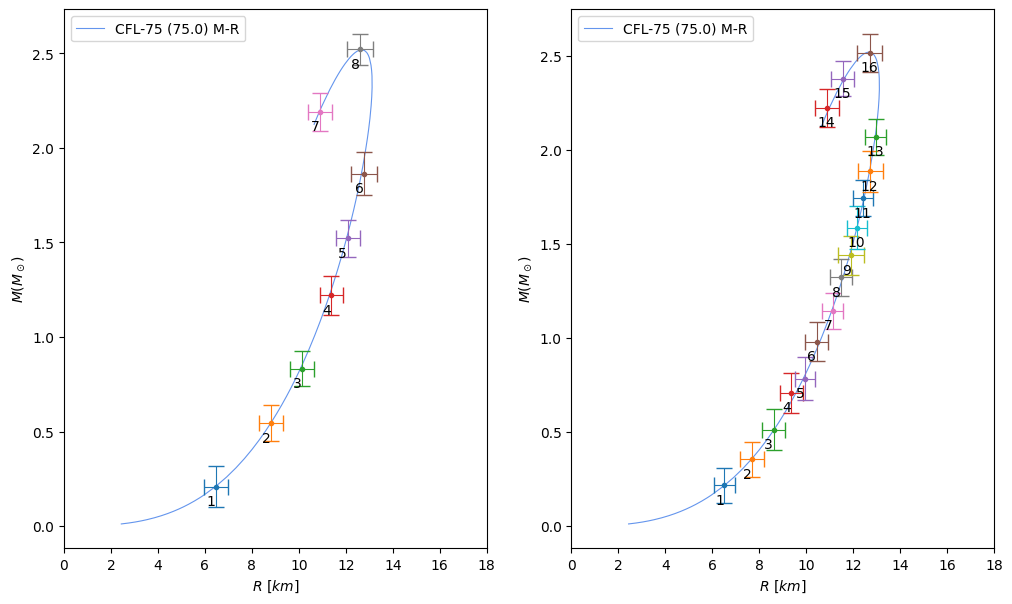

In [17]:
fig_CFL75_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL75_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-75",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-75",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL75_EOS.savefig("CFL-75_EOS_predict.pdf",dpi=300)

## **3.4 CFL-85 ($B=80$ $MeV\cdot fm^{-3}$, $Δ=50$ $MeV$) results**

> CFL-85

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.008701036260658301
rf:  0.004550440866789438
xgboost:  0.0031158938868725487
gradboost:  0.004968705716937424
dnn3:  0.0018584854729960314
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0018584854729960314
---------------------------------------------------------------------


> CFL-85

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.007899794588809456
rf:  0.0045050629374476
xgboost:  0.0025376943719143223
gradboost:  0.00480903665164463
dnn3:  0.0011972719776721828
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0011972719776721828
---------------------------------------------------------------------




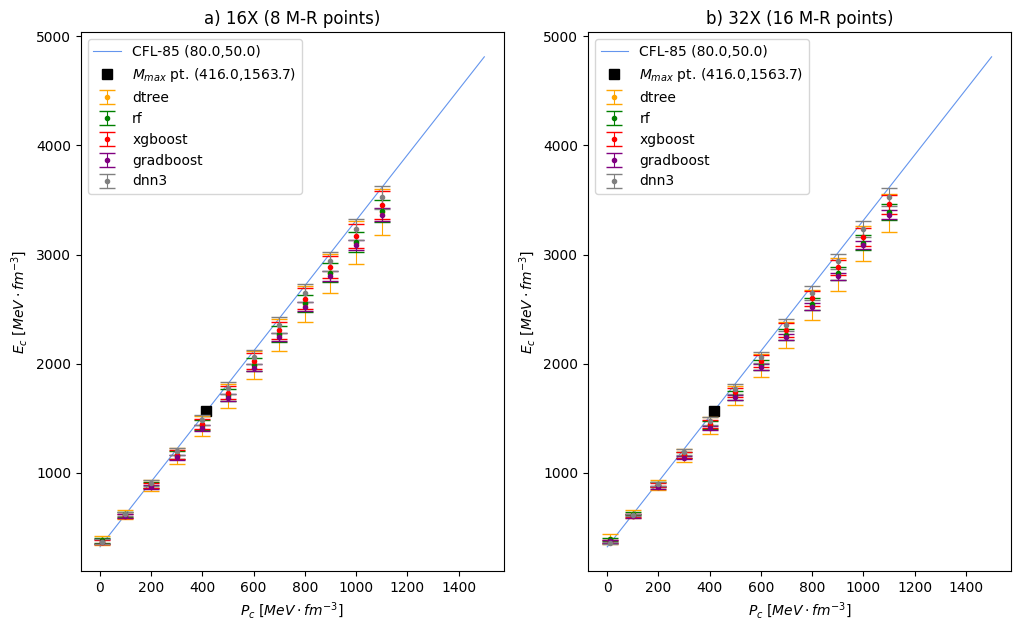

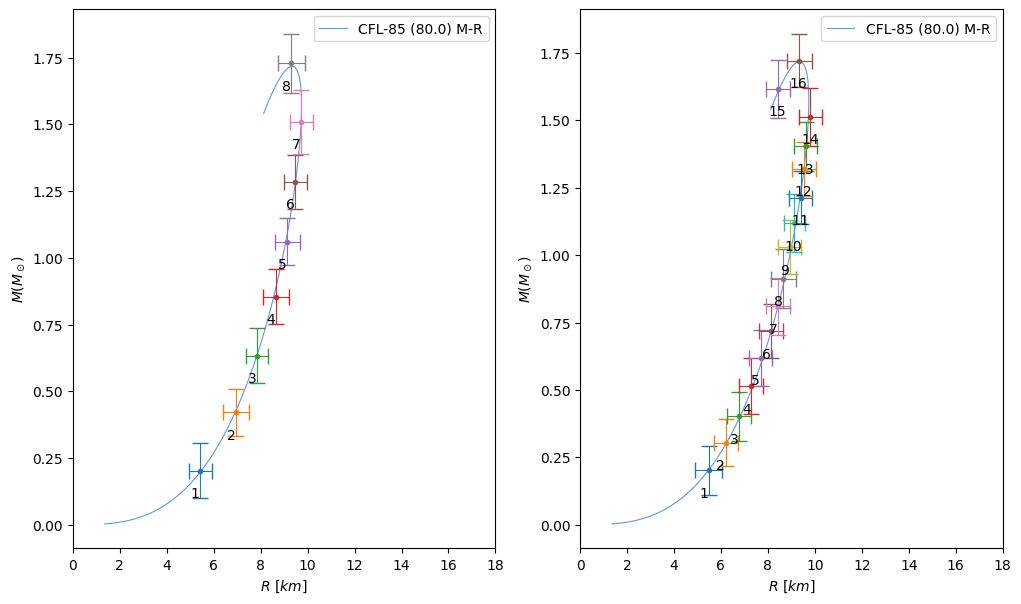

In [18]:
fig_CFL85_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL85_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-85",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-85",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL85_EOS.savefig("CFL-85_EOS_predict.pdf",dpi=300)

## **3.5 CFL-162 ($B=95$ $MeV\cdot fm^{-3}$, $Δ=190$ $MeV$) results**

> CFL-162

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.006766138305512184
rf:  0.0015557759740456277
xgboost:  0.0013610697782702682
gradboost:  0.0012216565459770084
dnn3:  0.00201231213621261
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0012216565459770084
---------------------------------------------------------------------


> CFL-162

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.006833607981395674
rf:  0.001162109219576338
xgboost:  0.0011723837725626616
gradboost:  0.0009088693285081777
dnn3:  0.0015220409411230342
---------------------------------------------------------------------
Best model:
gradboost
Best model MSLE:
0.0009088693285081777
---------------------------------------------------------------------




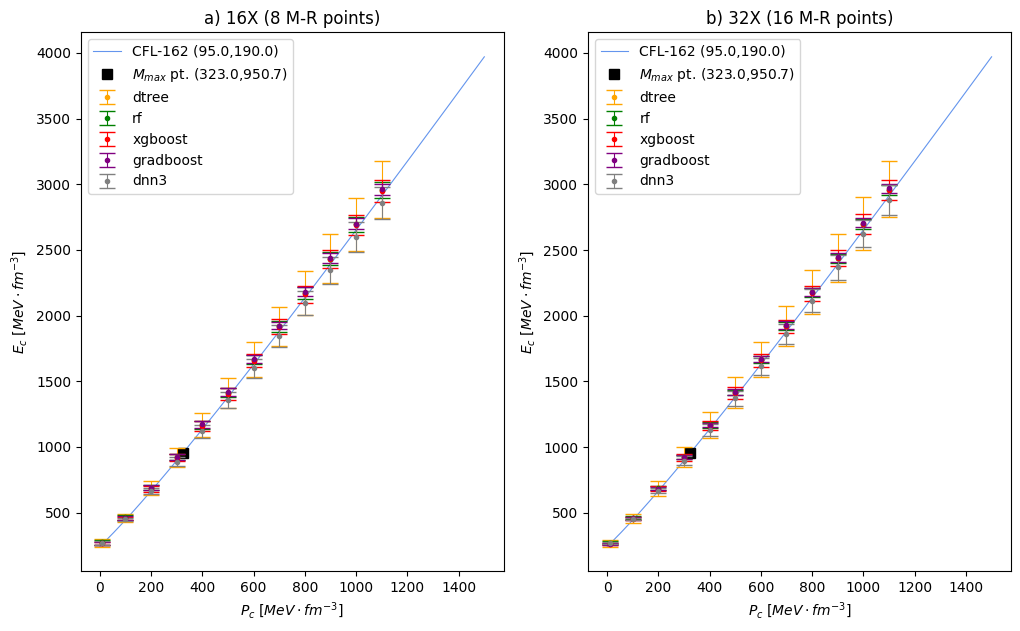

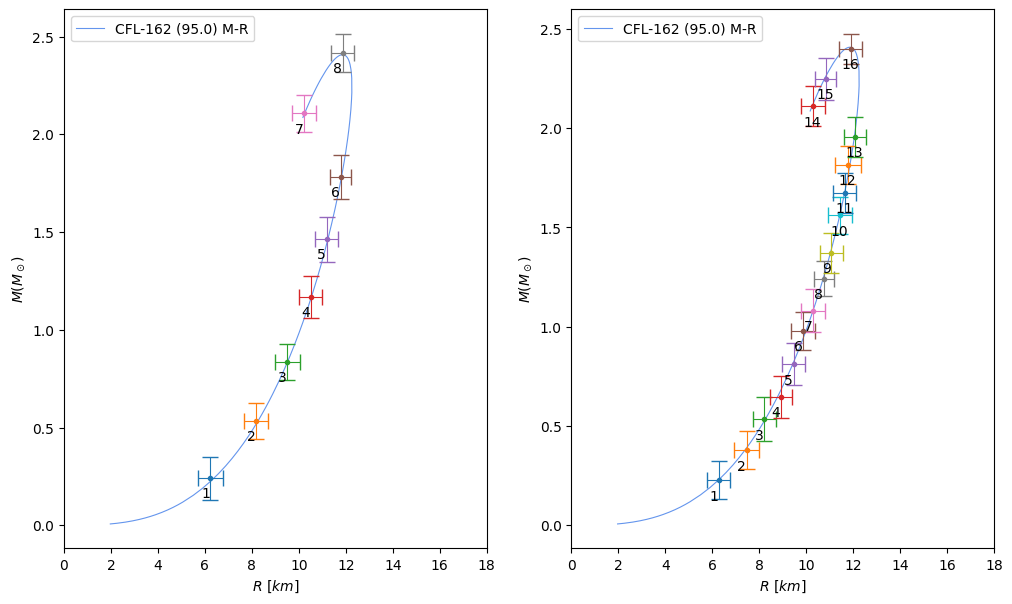

In [19]:
fig_CFL162_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL162_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-162",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-162",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL162_EOS.savefig("CFL-162_EOS_predict.pdf",dpi=300)

## **3.6 CFL-226 ($B=115$ $MeV\cdot fm^{-3}$, $Δ=90$ $MeV$) results**

> CFL-226

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.004394227655175304
rf:  0.002753847970256813
xgboost:  0.0022163621142176075
gradboost:  0.00253780905649287
dnn3:  0.002060803441294675
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.002060803441294675
---------------------------------------------------------------------


> CFL-226

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.00460036858840301
rf:  0.001980118213422279
xgboost:  0.0018101607056097806
gradboost:  0.002513016397178286
dnn3:  0.002076031381144516
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0018101607056097806
---------------------------------------------------------------------




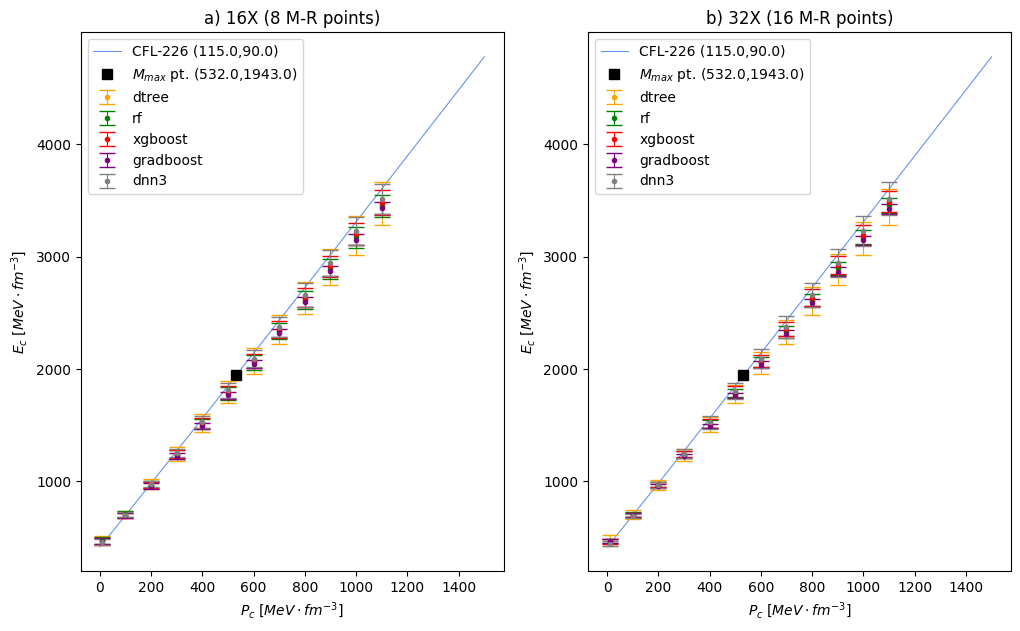

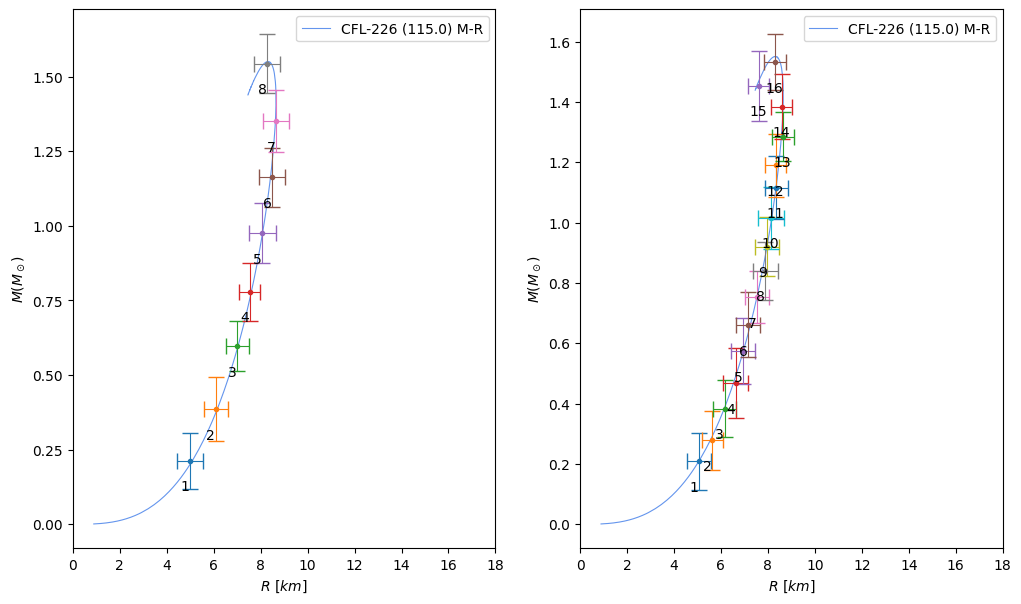

In [20]:
fig_CFL226_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL226_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-226",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-226",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL226_EOS.savefig("CFL-226_EOS_predict.pdf",dpi=300)

## **3.7 CFL-255 ($B=120$ $MeV\cdot fm^{-3}$, $Δ=220$ $MeV$) results**

> CFL-255

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.008007822885085919
rf:  0.004373468611877218
xgboost:  0.003810170699014735
gradboost:  0.006451502699045223
dnn3:  0.0027436483127656324
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0027436483127656324
---------------------------------------------------------------------


> CFL-255

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.010891500135252986
rf:  0.005312711260831743
xgboost:  0.0037896322803085115
gradboost:  0.007200597267568615
dnn3:  0.0010355084979826255
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0010355084979826255
---------------------------------------------------------------------




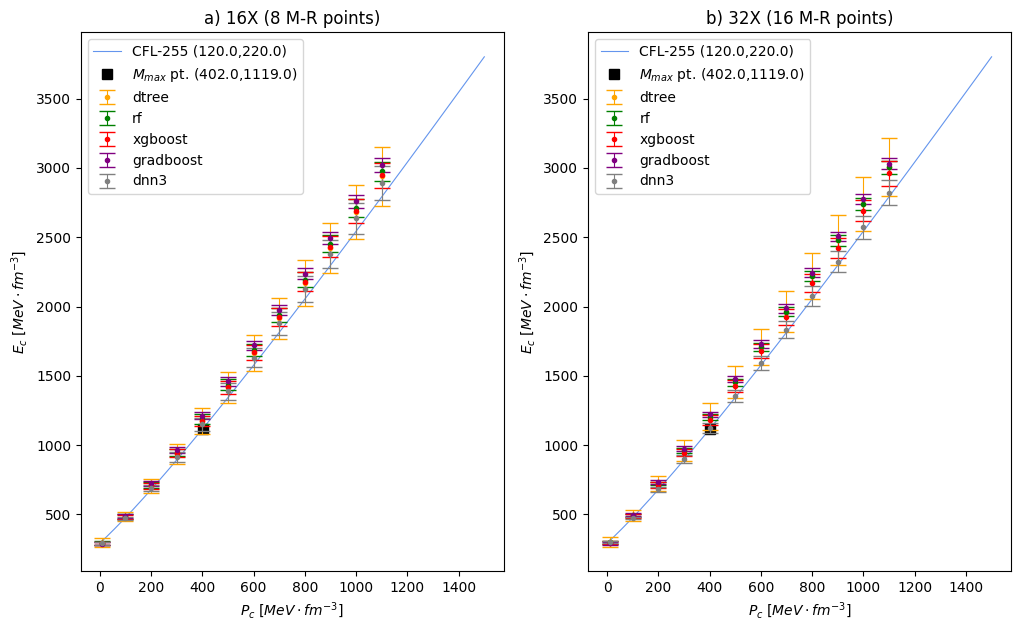

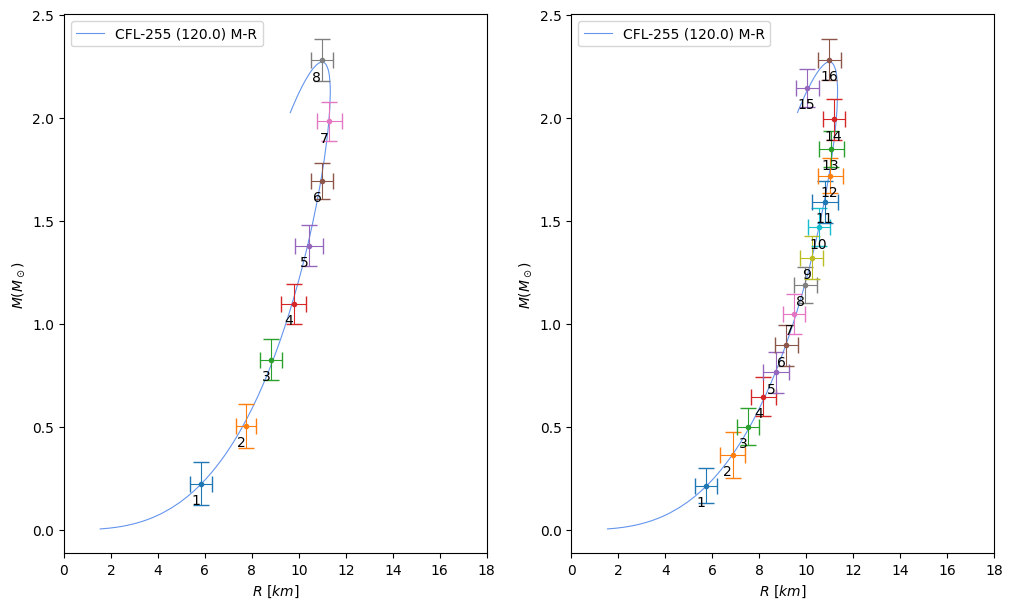

In [21]:
fig_CFL255_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL255_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-255",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-255",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL255_EOS.savefig("CFL-255_EOS_predict.pdf",dpi=300)

## **3.8 CFL-363 ($B=160$ $MeV\cdot fm^{-3}$, $Δ=210$ $MeV$) results**

> CFL-363

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.008094029703078457
rf:  0.0055717156688315575
xgboost:  0.004737135887641428
gradboost:  0.007030362802747092
dnn3:  0.004720625426105307
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.004720625426105307
---------------------------------------------------------------------


> CFL-363

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.011357693369162732
rf:  0.005392442810287355
xgboost:  0.0037319691360762977
gradboost:  0.006724948380768938
dnn3:  0.0016160125869827257
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0016160125869827257
---------------------------------------------------------------------




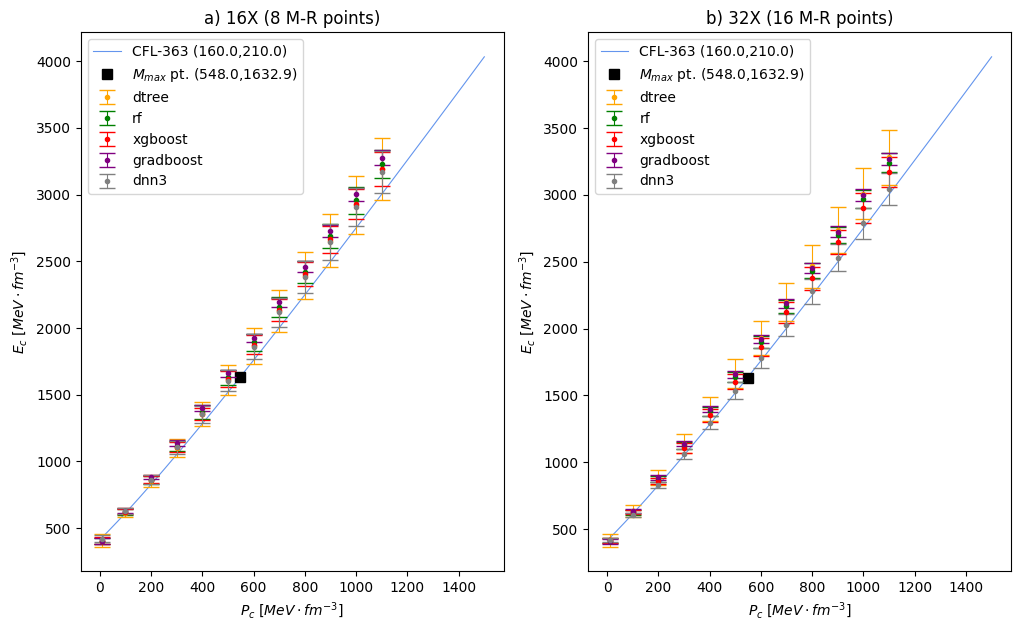

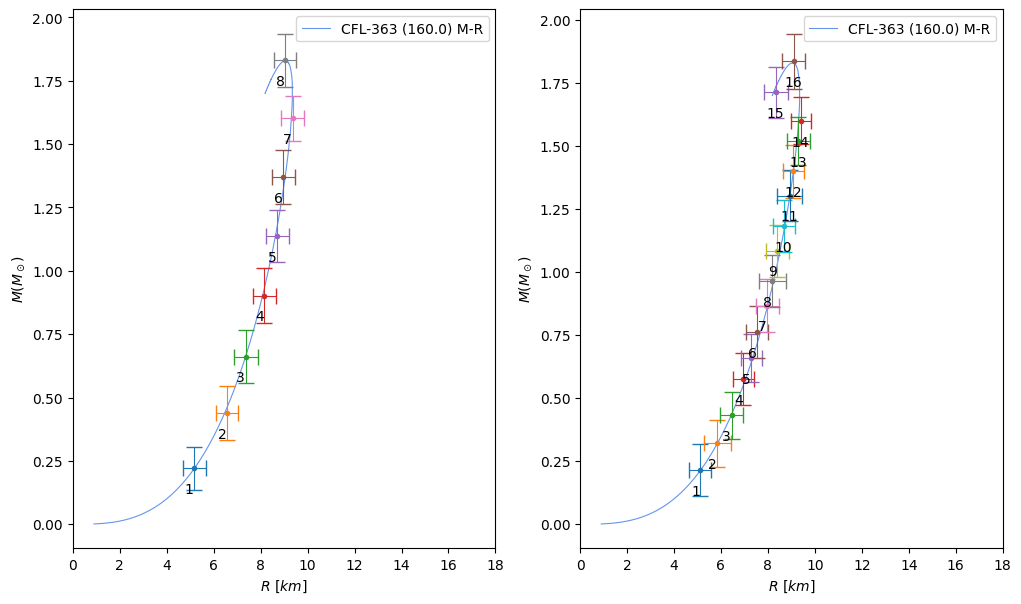

In [22]:
fig_CFL363_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL363_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-363",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-363",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL363_EOS.savefig("CFL-363_EOS_predict.pdf",dpi=300)

## **3.9 CFL-418 ($B=185$ $MeV\cdot fm^{-3}$, $Δ=240$ $MeV$) results**

> CFL-418

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.012871175910091752
rf:  0.010286346938448076
xgboost:  0.0072181030898458886
gradboost:  0.01328664237120824
dnn3:  0.0057942319683810814
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0057942319683810814
---------------------------------------------------------------------


> CFL-418

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.01600641039920128
rf:  0.010578117914353804
xgboost:  0.007152758728645226
gradboost:  0.013477020921810924
dnn3:  0.0029899855096858206
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.0029899855096858206
---------------------------------------------------------------------




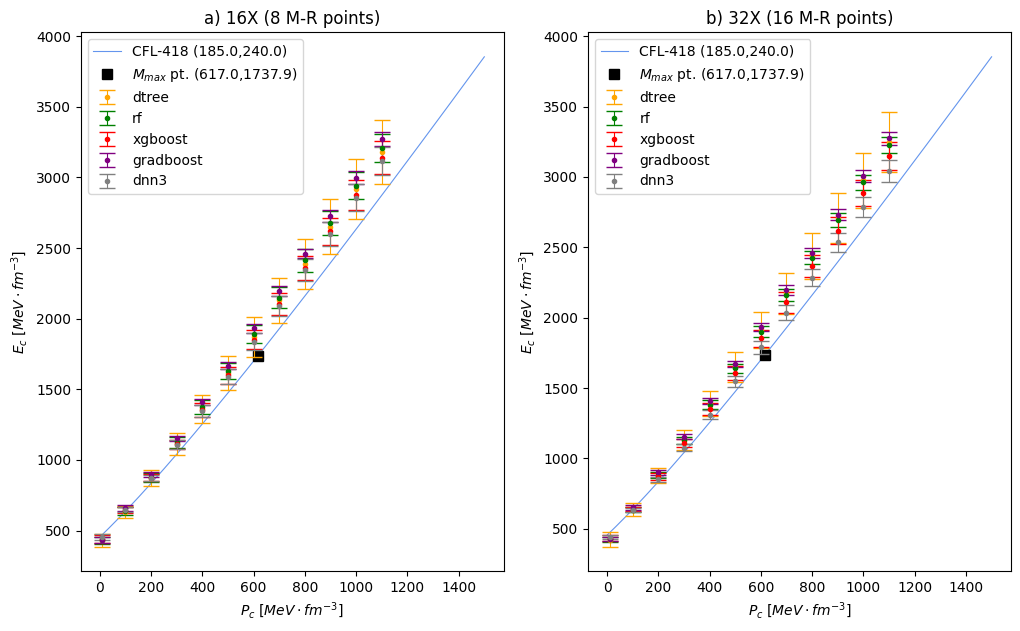

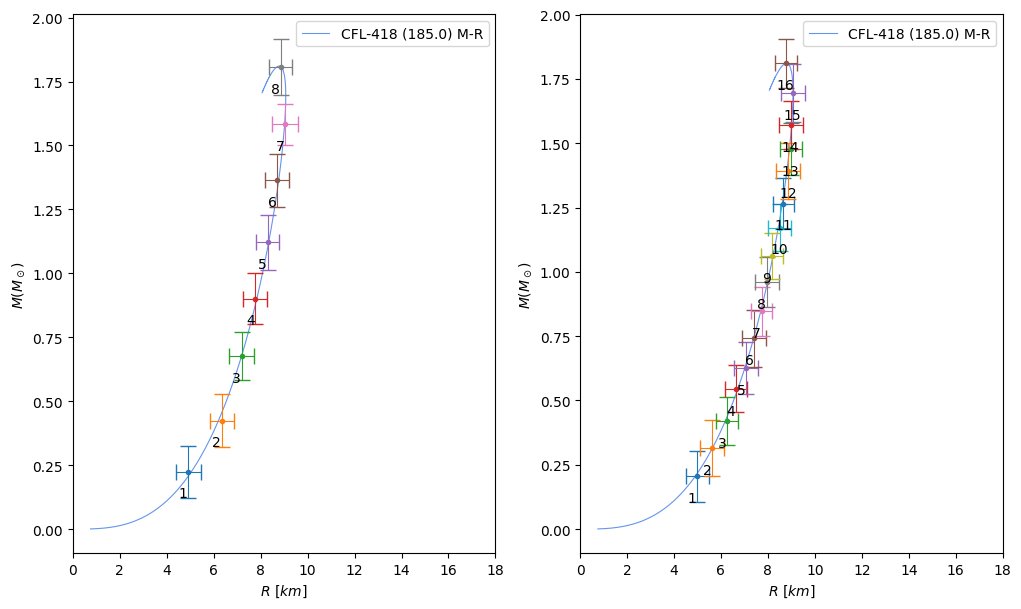

In [23]:
fig_CFL418_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL418_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-418",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-418",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL418_EOS.savefig("CFL-418_EOS_predict.pdf",dpi=300)

## **3.10 CFL-469 ($B=220$ $MeV\cdot fm^{-3}$, $Δ=190$ $MeV$) results**

> CFL-469

>> POINTS M-R: 8
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.008410378069693315
rf:  0.005144935414613573
xgboost:  0.0036347880704339173
gradboost:  0.004764205203851111
dnn3:  0.003755518551306042
---------------------------------------------------------------------
Best model:
xgboost
Best model MSLE:
0.0036347880704339173
---------------------------------------------------------------------


> CFL-469

>> POINTS M-R: 16
---------------------------------------------------------------------
Regression models and MSLE:
dtree:  0.007736095948822051
rf:  0.0043953221864723455
xgboost:  0.0032767848347707625
gradboost:  0.004329856829321329
dnn3:  0.002607890304610694
---------------------------------------------------------------------
Best model:
dnn3
Best model MSLE:
0.002607890304610694
---------------------------------------------------------------------




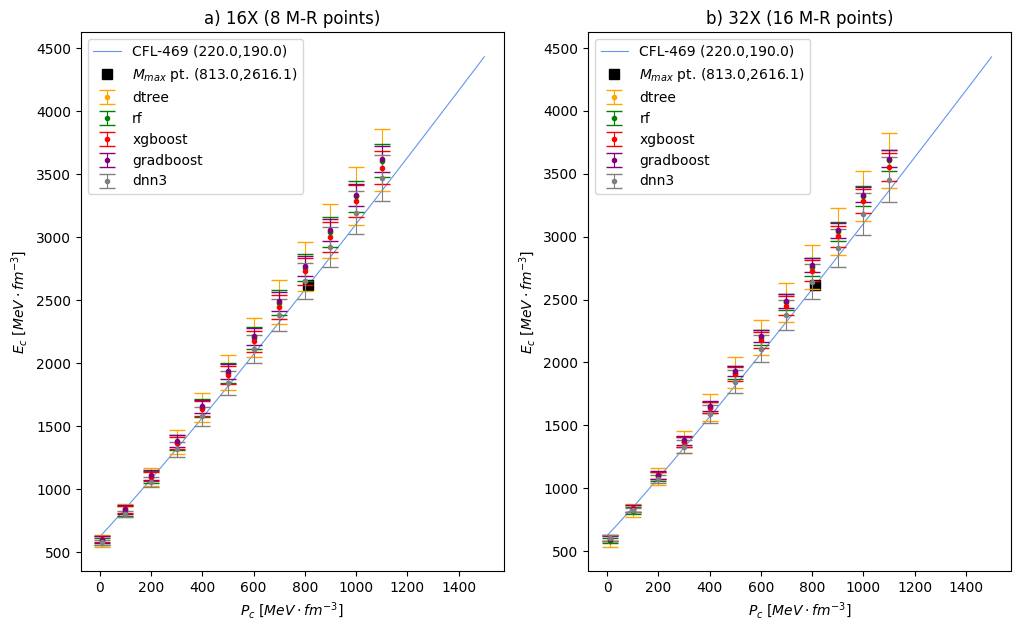

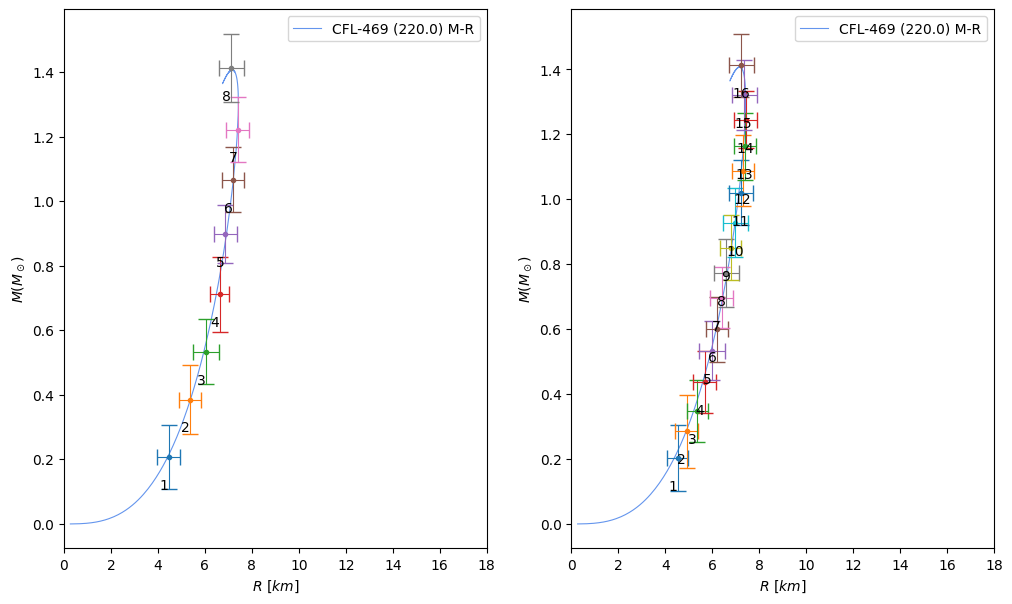

In [24]:
fig_CFL469_EOS, axes_EOS = plt.subplots(1,2,figsize=(12,7))
fig_CFL469_MR, axes_MR = plt.subplots(1,2,figsize=(12,7))

# 8 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[0],axis_MR=axes_MR[0],cfl_EOS="CFL-469",include_Mmax=True,reg_models_infos=models_16X_infos,points_MR=8,Pc_points=Pc_pts,iterations=100)
# 16 M-R points
predict_EOS_cflQS(axis_EOS=axes_EOS[1],axis_MR=axes_MR[1],cfl_EOS="CFL-469",include_Mmax=True,reg_models_infos=models_32X_infos,points_MR=16,Pc_points=Pc_pts,iterations=100)

axes_EOS[0].set_title("a) 16X (8 M-R points)")
axes_EOS[1].set_title("b) 32X (16 M-R points)")

fig_CFL469_EOS.savefig("CFL-469_EOS_predict.pdf",dpi=300)